# UNet

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/NachoGV/semantic-Segmentation-of-Brain-Metastases-in-MRI-Scans/blob/main/models/UNet.ipynb)

## Environment Set Up

### Requirements

In [ ]:
!pip install monai[einops]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 5.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2

### Colab Integration

In [ ]:
# Set up Colab Workspace
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

!ln -s /content/drive/MyDrive/TFM/data /content/data
!ln -s /content/drive/MyDrive/TFM/utils /content/utils
!ln -s /content/drive/MyDrive/TFM/outputs /content/outputs

Mounted at /content/drive


### Imports

In [ ]:
# System
import os
import time

# Data Load & Visualization
import numpy as np
import pandas as pd

# Monai
from monai.data import DataLoader
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.utils import set_determinism
from monai.inferers import sliding_window_inference

# PyTorch
import torch
from torch.utils.data import SequentialSampler

# Utils
from utils.Models import UNET
from utils.Transforms import Transforms
from utils.Plots import plot_gt_vs_pred
from utils.Dataset import UCSF_Dataset

### Config

In [ ]:
# Check if CUDA is available
device = None
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on GPU")
else:
    device = torch.device("cpu")
    print("Running on CPU")

# Print the device
print(f"Device: {device}")

Running on GPU
Device: cuda


In [ ]:
# Seeds
seed = 33
set_determinism(seed=seed) # Monai
np.random.seed(seed) # Numpy
torch.manual_seed(seed) # PyTorch

In [ ]:
# Configs
%matplotlib inline
%load_ext cudf.pandas
pd.set_option("display.max_columns", None)

### User Configurations

In [ ]:
# Model Configurations
model_name = "UNet"
model = UNET
b_size = 1 # Batch Size
t_size = None # Training Subjects (None for all)
v_size = None # Validation Subjects (None for all)
spatial_size = (240, 240, 160)

# Training Configuration
init_epoch = 56 # 0 if new training
best_epoch = 52 # Load model if not training from epoch 0 - None if new training
max_epochs = 100
best_metric = -1
best_metric_epoch = -1
if best_epoch is not None:
    best_metric_epoch = best_epoch
    if os.path.exists(f"outputs/{model_name}/{model_name}_metrics.csv"):
       df = pd.read_csv(f"outputs/{model_name}/{model_name}_metrics.csv")
       best_metric = df.loc[df["epoch"] == best_epoch]["metric"].values[0]

## Load Data

In [ ]:
# Load Subjects Information
train_df = pd.read_csv('data/TRAIN.csv')
val_df = pd.read_csv('data/VAL.csv')
test_df = pd.read_csv('data/TEST.csv')

train_df.head()

,SubjectID,Sex,CancerType,ScannerType,In-plane voxel size (mm),Matrix size,Prior Craniotomy/Biopsy/Resection,Age,Scanner Strength (Tesla),Slice Thickness (mm),NumberMetastases,VolumeMetastases_mm3,S-NM,S-V,S-VMax,S-VMin,S-VMean,S-VStd,S-VDiff,T1pre,FLAIR,T1post,T2Synth,Seg,BraTS-seg
0,100381A,Male,Lung,GE 1.5 T Signa HDxt,0.86x0.86,256x256x126,No,71.0,1.5,1.5,4.0,3082.045582,4.0,3082.045541,2445.030377,77.549672,770.511385,974.806455,4.146686e-05,data/raw/UCSF_BrainMetastases_TRAIN/100381A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100381A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100381A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100381A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100381A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100381A/10...
1,100414B,Female,Breast,GE 1.5 T Signa HDxt,0.59x0.59,512x512x50,No,52.0,1.5,3.0,5.0,84.446590,5.0,84.446586,22.656401,11.328201,16.889317,3.940386,3.629621e-06,data/raw/UCSF_BrainMetastases_TRAIN/100414B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100414B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100414B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100414B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100414B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100414B/10...
2,100132B,Male,Lung,GE 1.5 T Signa HDxt,0.5x0.5,512x512x156,No,55.0,1.5,1.2,5.0,734.400029,5.0,734.400029,236.700009,81.300003,146.880006,64.989060,1.136868e-13,data/raw/UCSF_BrainMetastases_TRAIN/100132B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100132B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100132B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100132B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100132B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100132B/10...
3,100212A,Female,Lung,GE 1.5 T Signa HDxt,1.17x1.17,256x256x98,No,52.0,1.5,1.5,9.0,208.062478,9.0,208.062474,43.260514,16.480196,23.118053,7.876000,3.481233e-06,data/raw/UCSF_BrainMetastases_TRAIN/100212A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100212A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100212A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100212A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100212A/10...,data/raw/UCSF_BrainMetastases_TRAIN/100212A/10...
4,100243B,Female,Breast,GE 1.5 T Signa HDxt,0.86x0.86,256x256x100,No,55.0,1.5,1.5,6.0,517.367105,6.0,517.367098,173.932836,8.862820,86.227850,52.711028,6.960829e-06,data/raw/UCSF_BrainMetastases_TRAIN/100243B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100243B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100243B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100243B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100243B/10...,data/raw/UCSF_BrainMetastases_TRAIN/100243B/10...


In [ ]:
transforms = Transforms(seed)

# Train Dataset
train_images = [train_df['T1pre'], train_df['FLAIR'], train_df['T1post'], train_df['T2Synth']]
train_labels = train_df['BraTS-seg']
train_dataset = UCSF_Dataset(train_images, train_labels, transforms.train(spatial_size=spatial_size), t_size)

# Validation Dataset
val_images = [val_df['T1pre'], val_df['FLAIR'], val_df['T1post'], val_df['T2Synth']]
val_labels = val_df['BraTS-seg']
val_dataset = UCSF_Dataset(val_images, val_labels, transforms.val(), v_size)

# Samplers
train_sampler = SequentialSampler(train_dataset)
val_sampler = SequentialSampler(val_dataset)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=b_size, shuffle=False, sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, sampler=val_sampler)

## Training

### Parameters

In [ ]:
# Training
VAL_AMP = True
lr = 1e-4
weight_decay = 1e-5

# Report Frequency
plt_imgs = []
val_interval = 1
plot_interval = 1
best_metric_update = False
best_metric_update_epoch = best_epoch if best_epoch is not None else -1
max_step = len(train_dataset) // train_loader.batch_size - 1
max_val_step = len(val_dataset) // val_loader.batch_size - 3

# Metrics Storages
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
val_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

### Model, Loss, Optimizer & Inference

In [ ]:
# Model
model.to(device)

# Load model from file
if init_epoch is not None:
    if os.path.exists(f"outputs/{model_name}/last_{model_name}_{init_epoch}.pth"):
        model.load_state_dict(torch.load(f"outputs/{model_name}/last_{model_name}_{init_epoch}.pth"))

# Report File Headers
if init_epoch is None:
    with open(f"outputs/{model_name}/{model_name}_metrics.csv", "a") as f:
      f.write(f"epoch,metric,metric_tc,metric_wt,metric_et,train_loss,val_loss\n")

# Loss Function
loss_function = DiceLoss(smooth_nr=1e-5, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

# Metrics
dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

# Inference Method
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=spatial_size,
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)

# AMP to accelerate training
scaler = torch.cuda.amp.GradScaler()

# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

### Training Process

----------
epoch 57/100
TRAIN
   Batch 1/248, train_loss: 0.1308, step time: 5.0619
   Batch 2/248, train_loss: 0.9998, step time: 0.3572
   Batch 3/248, train_loss: 0.9542, step time: 0.3678
   Batch 4/248, train_loss: 0.9998, step time: 0.3551
   Batch 5/248, train_loss: 0.8230, step time: 0.3815
   Batch 6/248, train_loss: 0.7237, step time: 0.3768
   Batch 7/248, train_loss: 0.2453, step time: 0.3451
   Batch 8/248, train_loss: 0.7390, step time: 0.3566
   Batch 9/248, train_loss: 0.1136, step time: 0.3652
   Batch 10/248, train_loss: 0.9009, step time: 0.3734
   Batch 11/248, train_loss: 0.7636, step time: 0.3484
   Batch 12/248, train_loss: 0.9993, step time: 0.3795
   Batch 13/248, train_loss: 0.9973, step time: 0.3758
   Batch 14/248, train_loss: 0.3165, step time: 0.3444
   Batch 15/248, train_loss: 0.8944, step time: 0.3485
   Batch 16/248, train_loss: 0.7224, step time: 0.3854
   Batch 17/248, train_loss: 0.9991, step time: 0.3403
   Batch 18/248, train_loss: 0.9954, step ti

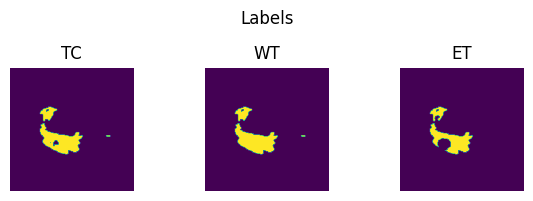

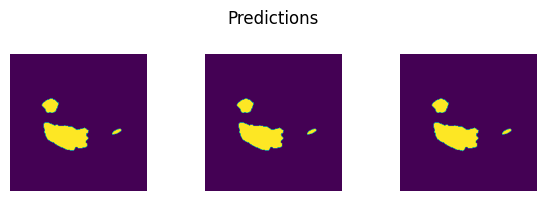

VAL
   Batch 1/31, val_loss: 0.8843
   Batch 2/31, val_loss: 0.9992
   Batch 3/31, val_loss: 0.9960
   Batch 4/31, val_loss: 0.9935
   Batch 5/31, val_loss: 0.9999
   Batch 6/31, val_loss: 0.7362
   Batch 7/31, val_loss: 0.8652
   Batch 8/31, val_loss: 0.9838
   Batch 9/31, val_loss: 0.7243
   Batch 10/31, val_loss: 0.9790
   Batch 11/31, val_loss: 0.8691
   Batch 12/31, val_loss: 0.9760
   Batch 13/31, val_loss: 0.9850
   Batch 14/31, val_loss: 0.9703
   Batch 15/31, val_loss: 0.9972
   Batch 16/31, val_loss: 0.9908
   Batch 17/31, val_loss: 0.9995
   Batch 18/31, val_loss: 0.9854
   Batch 19/31, val_loss: 0.7897
   Batch 20/31, val_loss: 0.8808
   Batch 21/31, val_loss: 0.9379
   Batch 22/31, val_loss: 0.9968
   Batch 23/31, val_loss: 0.9945
   Batch 24/31, val_loss: 0.7550
   Batch 25/31, val_loss: 0.8239
   Batch 26/31, val_loss: 0.9592
   Batch 27/31, val_loss: 0.9988
   Batch 28/31, val_loss: 0.8001
   Batch 29/31, val_loss: 0.9982
   Batch 30/31, val_loss: 0.9961
   Batch 31/31,

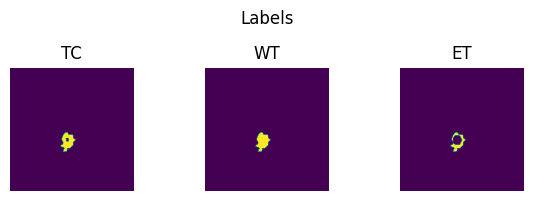

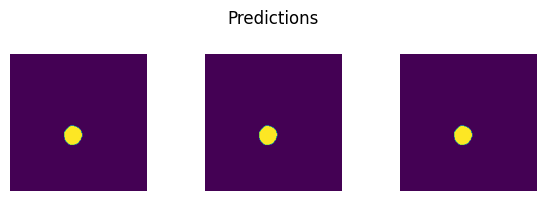

epoch 57
   average train loss: 0.6371
   average validation loss: 0.9310
   saved as best model: True
   current mean dice: 0.2936
   current TC dice: 0.3067
   current WT dice: 0.3125
   current ET dice: 0.2895
Best Mean Metric: 0.2936
time consuming of epoch 57 is: 4023.2431
----------
epoch 58/100
TRAIN
   Batch 1/248, train_loss: 0.1241, step time: 0.3477
   Batch 2/248, train_loss: 0.9988, step time: 0.3504
   Batch 3/248, train_loss: 0.9481, step time: 0.3505
   Batch 4/248, train_loss: 0.9996, step time: 0.3468
   Batch 5/248, train_loss: 0.7764, step time: 0.3653
   Batch 6/248, train_loss: 0.7536, step time: 0.3599
   Batch 7/248, train_loss: 0.1152, step time: 0.3723
   Batch 8/248, train_loss: 0.7561, step time: 0.3821
   Batch 9/248, train_loss: 0.0878, step time: 0.3660
   Batch 10/248, train_loss: 0.8938, step time: 0.3833
   Batch 11/248, train_loss: 0.7480, step time: 0.3721
   Batch 12/248, train_loss: 0.9940, step time: 0.3607
   Batch 13/248, train_loss: 0.9479, ste

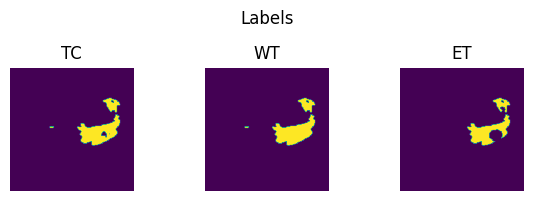

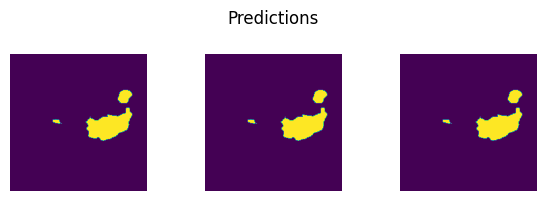

VAL
   Batch 1/31, val_loss: 0.8881
   Batch 2/31, val_loss: 0.9988
   Batch 3/31, val_loss: 0.9950
   Batch 4/31, val_loss: 0.9933
   Batch 5/31, val_loss: 0.9999
   Batch 6/31, val_loss: 0.7367
   Batch 7/31, val_loss: 0.8652
   Batch 8/31, val_loss: 0.9854
   Batch 9/31, val_loss: 0.7257
   Batch 10/31, val_loss: 0.9761
   Batch 11/31, val_loss: 0.8618
   Batch 12/31, val_loss: 0.9768
   Batch 13/31, val_loss: 0.9915
   Batch 14/31, val_loss: 0.9694
   Batch 15/31, val_loss: 0.9998
   Batch 16/31, val_loss: 0.9920
   Batch 17/31, val_loss: 0.9977
   Batch 18/31, val_loss: 0.9870
   Batch 19/31, val_loss: 0.7798
   Batch 20/31, val_loss: 0.8834
   Batch 21/31, val_loss: 0.9344
   Batch 22/31, val_loss: 0.9974
   Batch 23/31, val_loss: 0.9918
   Batch 24/31, val_loss: 0.7592
   Batch 25/31, val_loss: 0.8222
   Batch 26/31, val_loss: 0.9565
   Batch 27/31, val_loss: 0.9971
   Batch 28/31, val_loss: 0.7944
   Batch 29/31, val_loss: 0.9988
   Batch 30/31, val_loss: 0.9939
   Batch 31/31,

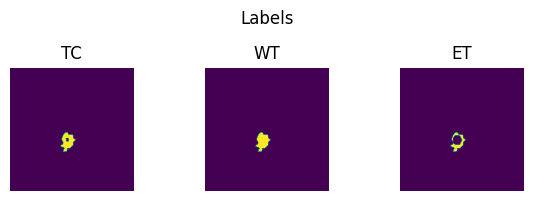

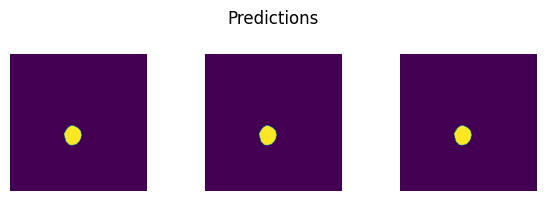

epoch 58
   average train loss: 0.6280
   average validation loss: 0.9304
   saved as best model: True
   current mean dice: 0.2970
   current TC dice: 0.3106
   current WT dice: 0.3165
   current ET dice: 0.2920
Best Mean Metric: 0.2970
time consuming of epoch 58 is: 1401.9057
----------
epoch 59/100
TRAIN
   Batch 1/248, train_loss: 0.1218, step time: 0.3623
   Batch 2/248, train_loss: 0.9988, step time: 0.3440
   Batch 3/248, train_loss: 0.9406, step time: 0.3848
   Batch 4/248, train_loss: 0.9996, step time: 0.3720
   Batch 5/248, train_loss: 0.7725, step time: 0.3908
   Batch 6/248, train_loss: 0.7494, step time: 0.3848
   Batch 7/248, train_loss: 0.1139, step time: 0.3723
   Batch 8/248, train_loss: 0.7553, step time: 0.3852
   Batch 9/248, train_loss: 0.0877, step time: 0.3833
   Batch 10/248, train_loss: 0.8909, step time: 0.3756
   Batch 11/248, train_loss: 0.7361, step time: 0.3867
   Batch 12/248, train_loss: 0.9905, step time: 0.3914
   Batch 13/248, train_loss: 0.9419, ste

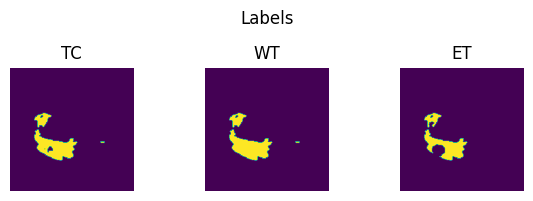

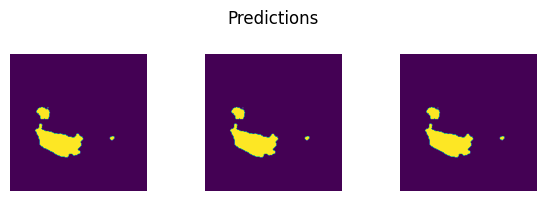

VAL
   Batch 1/31, val_loss: 0.8842
   Batch 2/31, val_loss: 0.9991
   Batch 3/31, val_loss: 0.9917
   Batch 4/31, val_loss: 0.9930
   Batch 5/31, val_loss: 0.9998
   Batch 6/31, val_loss: 0.7319
   Batch 7/31, val_loss: 0.8641
   Batch 8/31, val_loss: 0.9834
   Batch 9/31, val_loss: 0.7249
   Batch 10/31, val_loss: 0.9710
   Batch 11/31, val_loss: 0.8614
   Batch 12/31, val_loss: 0.9774
   Batch 13/31, val_loss: 0.9930
   Batch 14/31, val_loss: 0.9709
   Batch 15/31, val_loss: 0.9962
   Batch 16/31, val_loss: 0.9912
   Batch 17/31, val_loss: 0.9993
   Batch 18/31, val_loss: 0.9826
   Batch 19/31, val_loss: 0.7891
   Batch 20/31, val_loss: 0.8849
   Batch 21/31, val_loss: 0.9362
   Batch 22/31, val_loss: 0.9978
   Batch 23/31, val_loss: 0.9919
   Batch 24/31, val_loss: 0.7591
   Batch 25/31, val_loss: 0.8202
   Batch 26/31, val_loss: 0.9555
   Batch 27/31, val_loss: 0.9980
   Batch 28/31, val_loss: 0.7924
   Batch 29/31, val_loss: 0.9983
   Batch 30/31, val_loss: 0.9932
   Batch 31/31,

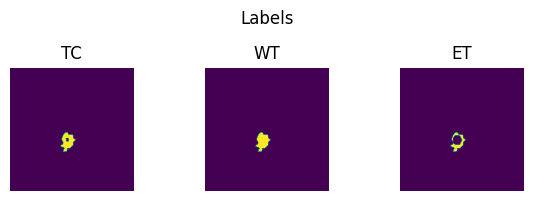

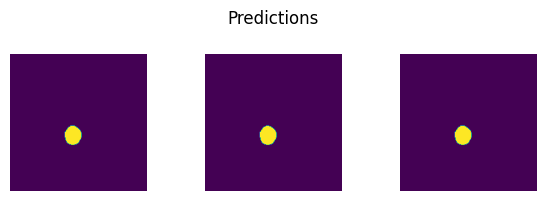

epoch 59
   average train loss: 0.6215
   average validation loss: 0.9299
   saved as best model: True
   current mean dice: 0.3043
   current TC dice: 0.3184
   current WT dice: 0.3243
   current ET dice: 0.2990
Best Mean Metric: 0.3043
time consuming of epoch 59 is: 1405.6850
----------
epoch 60/100
TRAIN
   Batch 1/248, train_loss: 0.1187, step time: 0.3879
   Batch 2/248, train_loss: 0.9979, step time: 0.3642
   Batch 3/248, train_loss: 0.9404, step time: 0.3779
   Batch 4/248, train_loss: 0.9998, step time: 0.3514
   Batch 5/248, train_loss: 0.7586, step time: 0.3564
   Batch 6/248, train_loss: 0.7418, step time: 0.3778
   Batch 7/248, train_loss: 0.1189, step time: 0.3854
   Batch 8/248, train_loss: 0.7443, step time: 0.3519
   Batch 9/248, train_loss: 0.0805, step time: 0.3869
   Batch 10/248, train_loss: 0.8834, step time: 0.3753
   Batch 11/248, train_loss: 0.7251, step time: 0.3490
   Batch 12/248, train_loss: 0.9852, step time: 0.3476
   Batch 13/248, train_loss: 0.9547, ste

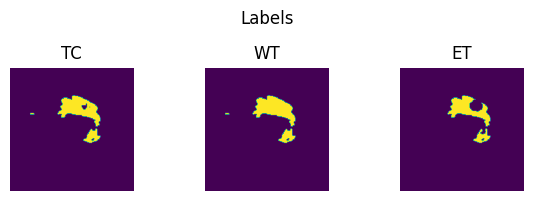

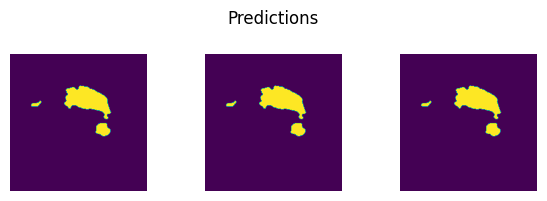

VAL
   Batch 1/31, val_loss: 0.8820
   Batch 2/31, val_loss: 0.9994
   Batch 3/31, val_loss: 0.9963
   Batch 4/31, val_loss: 0.9929
   Batch 5/31, val_loss: 0.9999
   Batch 6/31, val_loss: 0.7376
   Batch 7/31, val_loss: 0.8670
   Batch 8/31, val_loss: 0.9821
   Batch 9/31, val_loss: 0.7344
   Batch 10/31, val_loss: 0.9775
   Batch 11/31, val_loss: 0.8625
   Batch 12/31, val_loss: 0.9775
   Batch 13/31, val_loss: 0.9863
   Batch 14/31, val_loss: 0.9707
   Batch 15/31, val_loss: 0.9989
   Batch 16/31, val_loss: 0.9913
   Batch 17/31, val_loss: 0.9993
   Batch 18/31, val_loss: 0.9845
   Batch 19/31, val_loss: 0.7756
   Batch 20/31, val_loss: 0.8826
   Batch 21/31, val_loss: 0.9343
   Batch 22/31, val_loss: 0.9986
   Batch 23/31, val_loss: 0.9924
   Batch 24/31, val_loss: 0.7632
   Batch 25/31, val_loss: 0.8203
   Batch 26/31, val_loss: 0.9542
   Batch 27/31, val_loss: 0.9975
   Batch 28/31, val_loss: 0.7934
   Batch 29/31, val_loss: 0.9973
   Batch 30/31, val_loss: 0.9936
   Batch 31/31,

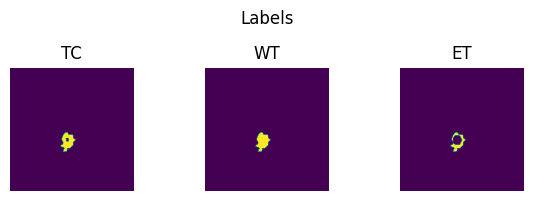

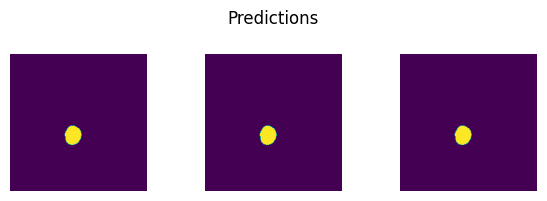

epoch 60
   average train loss: 0.6183
   average validation loss: 0.9302
   saved as best model: False
   current mean dice: 0.3018
   current TC dice: 0.3159
   current WT dice: 0.3219
   current ET dice: 0.2962
Best Mean Metric: 0.3043
time consuming of epoch 60 is: 1397.4537
----------
epoch 61/100
TRAIN
   Batch 1/248, train_loss: 0.1255, step time: 0.3586
   Batch 2/248, train_loss: 0.9993, step time: 0.3930
   Batch 3/248, train_loss: 0.9381, step time: 0.3847
   Batch 4/248, train_loss: 0.9999, step time: 0.3833
   Batch 5/248, train_loss: 0.7459, step time: 0.3765
   Batch 6/248, train_loss: 0.7617, step time: 0.3817
   Batch 7/248, train_loss: 0.1197, step time: 0.3645
   Batch 8/248, train_loss: 0.7534, step time: 0.3703
   Batch 9/248, train_loss: 0.0779, step time: 0.3561
   Batch 10/248, train_loss: 0.8788, step time: 0.3724
   Batch 11/248, train_loss: 0.7132, step time: 0.3585
   Batch 12/248, train_loss: 0.9878, step time: 0.3851
   Batch 13/248, train_loss: 0.9518, st

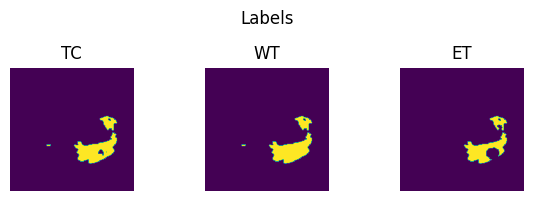

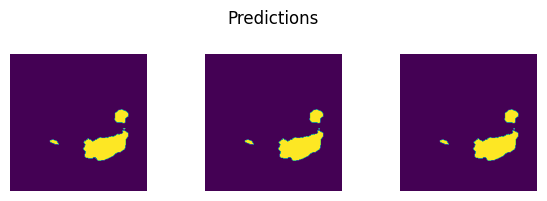

VAL
   Batch 1/31, val_loss: 0.8865
   Batch 2/31, val_loss: 0.9993
   Batch 3/31, val_loss: 0.9850
   Batch 4/31, val_loss: 0.9910
   Batch 5/31, val_loss: 0.9998
   Batch 6/31, val_loss: 0.7420
   Batch 7/31, val_loss: 0.8651
   Batch 8/31, val_loss: 0.9811
   Batch 9/31, val_loss: 0.7349
   Batch 10/31, val_loss: 0.9750
   Batch 11/31, val_loss: 0.8560
   Batch 12/31, val_loss: 0.9774
   Batch 13/31, val_loss: 0.9933
   Batch 14/31, val_loss: 0.9698
   Batch 15/31, val_loss: 0.9998
   Batch 16/31, val_loss: 0.9900
   Batch 17/31, val_loss: 0.9994
   Batch 18/31, val_loss: 0.9771
   Batch 19/31, val_loss: 0.7787
   Batch 20/31, val_loss: 0.8837
   Batch 21/31, val_loss: 0.9364
   Batch 22/31, val_loss: 0.9958
   Batch 23/31, val_loss: 0.9920
   Batch 24/31, val_loss: 0.7608
   Batch 25/31, val_loss: 0.8172
   Batch 26/31, val_loss: 0.9534
   Batch 27/31, val_loss: 0.9975
   Batch 28/31, val_loss: 0.7899
   Batch 29/31, val_loss: 0.9957
   Batch 30/31, val_loss: 0.9955
   Batch 31/31,

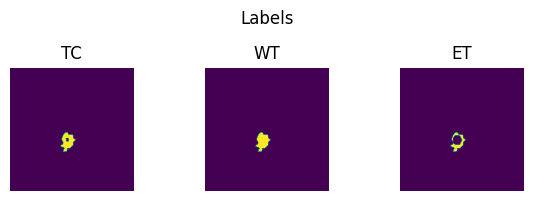

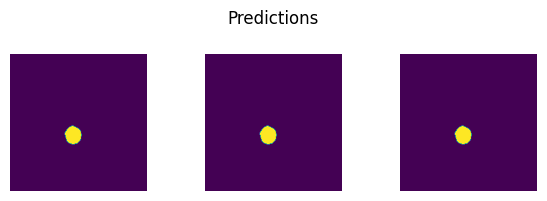

epoch 61
   average train loss: 0.6126
   average validation loss: 0.9295
   saved as best model: False
   current mean dice: 0.3038
   current TC dice: 0.3180
   current WT dice: 0.3236
   current ET dice: 0.2986
Best Mean Metric: 0.3043
time consuming of epoch 61 is: 1405.1428
----------
epoch 62/100
TRAIN
   Batch 1/248, train_loss: 0.1176, step time: 0.3630
   Batch 2/248, train_loss: 0.9981, step time: 0.3836
   Batch 3/248, train_loss: 0.9324, step time: 0.3867
   Batch 4/248, train_loss: 0.9996, step time: 0.3640
   Batch 5/248, train_loss: 0.7519, step time: 0.3762
   Batch 6/248, train_loss: 0.7772, step time: 0.3446
   Batch 7/248, train_loss: 0.1361, step time: 0.3443
   Batch 8/248, train_loss: 0.7447, step time: 0.3828
   Batch 9/248, train_loss: 0.0757, step time: 0.3618
   Batch 10/248, train_loss: 0.8694, step time: 0.3661
   Batch 11/248, train_loss: 0.7051, step time: 0.3800
   Batch 12/248, train_loss: 0.9944, step time: 0.3601
   Batch 13/248, train_loss: 0.9487, st

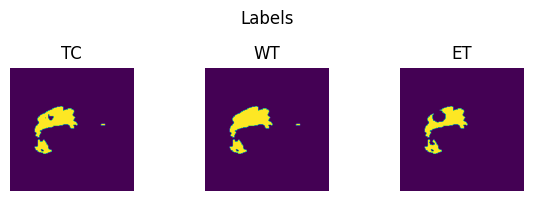

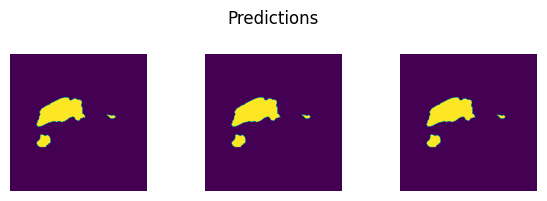

VAL
   Batch 1/31, val_loss: 0.8813
   Batch 2/31, val_loss: 0.9987
   Batch 3/31, val_loss: 0.9957
   Batch 4/31, val_loss: 0.9926
   Batch 5/31, val_loss: 0.9998
   Batch 6/31, val_loss: 0.7355
   Batch 7/31, val_loss: 0.8627
   Batch 8/31, val_loss: 0.9862
   Batch 9/31, val_loss: 0.7328
   Batch 10/31, val_loss: 0.9724
   Batch 11/31, val_loss: 0.8538
   Batch 12/31, val_loss: 0.9765
   Batch 13/31, val_loss: 0.9927
   Batch 14/31, val_loss: 0.9714
   Batch 15/31, val_loss: 0.9929
   Batch 16/31, val_loss: 0.9922
   Batch 17/31, val_loss: 0.9985
   Batch 18/31, val_loss: 0.9849
   Batch 19/31, val_loss: 0.7862
   Batch 20/31, val_loss: 0.8845
   Batch 21/31, val_loss: 0.9284
   Batch 22/31, val_loss: 0.9971
   Batch 23/31, val_loss: 0.9908
   Batch 24/31, val_loss: 0.7563
   Batch 25/31, val_loss: 0.8191
   Batch 26/31, val_loss: 0.9512
   Batch 27/31, val_loss: 0.9970
   Batch 28/31, val_loss: 0.7889
   Batch 29/31, val_loss: 0.9964
   Batch 30/31, val_loss: 0.9854
   Batch 31/31,

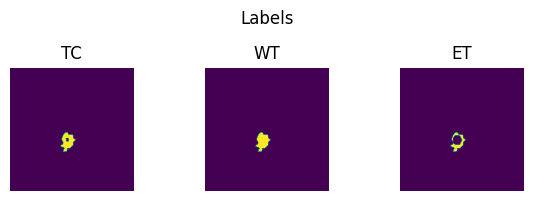

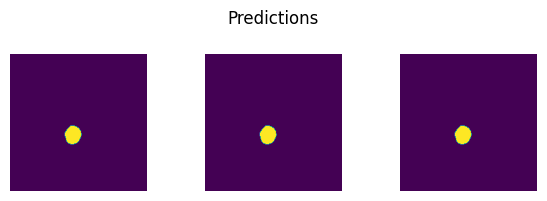

epoch 62
   average train loss: 0.6107
   average validation loss: 0.9289
   saved as best model: True
   current mean dice: 0.3074
   current TC dice: 0.3217
   current WT dice: 0.3279
   current ET dice: 0.3018
Best Mean Metric: 0.3074
time consuming of epoch 62 is: 1402.8798
----------
epoch 63/100
TRAIN
   Batch 1/248, train_loss: 0.1117, step time: 0.3525
   Batch 2/248, train_loss: 0.9995, step time: 0.3485
   Batch 3/248, train_loss: 0.9390, step time: 0.3867
   Batch 4/248, train_loss: 0.9996, step time: 0.3672
   Batch 5/248, train_loss: 0.7552, step time: 0.3493
   Batch 6/248, train_loss: 0.8146, step time: 0.3843
   Batch 7/248, train_loss: 0.1127, step time: 0.3868
   Batch 8/248, train_loss: 0.7576, step time: 0.3411
   Batch 9/248, train_loss: 0.0791, step time: 0.3843
   Batch 10/248, train_loss: 0.8701, step time: 0.3870
   Batch 11/248, train_loss: 0.6930, step time: 0.3418
   Batch 12/248, train_loss: 0.9911, step time: 0.3657
   Batch 13/248, train_loss: 0.9540, ste

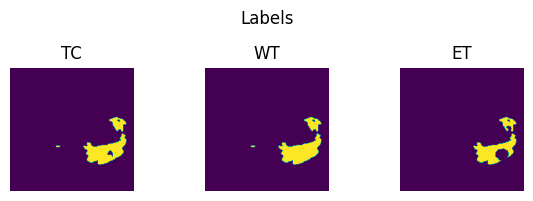

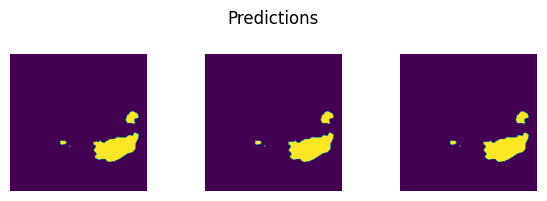

VAL
   Batch 1/31, val_loss: 0.8862
   Batch 2/31, val_loss: 0.9988
   Batch 3/31, val_loss: 0.9952
   Batch 4/31, val_loss: 0.9922
   Batch 5/31, val_loss: 0.9999
   Batch 6/31, val_loss: 0.7392
   Batch 7/31, val_loss: 0.8612
   Batch 8/31, val_loss: 0.9820
   Batch 9/31, val_loss: 0.7351
   Batch 10/31, val_loss: 0.9700
   Batch 11/31, val_loss: 0.8604
   Batch 12/31, val_loss: 0.9764
   Batch 13/31, val_loss: 0.9913
   Batch 14/31, val_loss: 0.9719
   Batch 15/31, val_loss: 0.9987
   Batch 16/31, val_loss: 0.9919
   Batch 17/31, val_loss: 0.9984
   Batch 18/31, val_loss: 0.9834
   Batch 19/31, val_loss: 0.7921
   Batch 20/31, val_loss: 0.8865
   Batch 21/31, val_loss: 0.9261
   Batch 22/31, val_loss: 0.9982
   Batch 23/31, val_loss: 0.9898
   Batch 24/31, val_loss: 0.7561
   Batch 25/31, val_loss: 0.8191
   Batch 26/31, val_loss: 0.9516
   Batch 27/31, val_loss: 0.9980
   Batch 28/31, val_loss: 0.7835
   Batch 29/31, val_loss: 0.9960
   Batch 30/31, val_loss: 0.9960
   Batch 31/31,

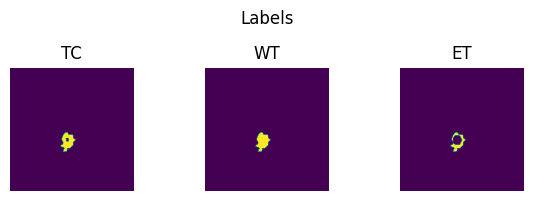

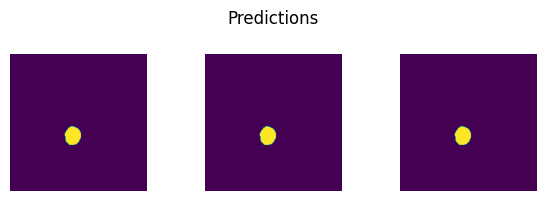

epoch 63
   average train loss: 0.6009
   average validation loss: 0.9296
   saved as best model: True
   current mean dice: 0.3086
   current TC dice: 0.3233
   current WT dice: 0.3293
   current ET dice: 0.3022
Best Mean Metric: 0.3086
time consuming of epoch 63 is: 1390.1658
----------
epoch 64/100
TRAIN
   Batch 1/248, train_loss: 0.1282, step time: 0.3850
   Batch 2/248, train_loss: 0.9998, step time: 0.3429
   Batch 3/248, train_loss: 0.9299, step time: 0.3399
   Batch 4/248, train_loss: 0.9998, step time: 0.3712
   Batch 5/248, train_loss: 0.7335, step time: 0.3654
   Batch 6/248, train_loss: 0.7248, step time: 0.3617
   Batch 7/248, train_loss: 0.1177, step time: 0.3432
   Batch 8/248, train_loss: 0.7569, step time: 0.3660
   Batch 9/248, train_loss: 0.0782, step time: 0.3441
   Batch 10/248, train_loss: 0.8620, step time: 0.3381
   Batch 11/248, train_loss: 0.6758, step time: 0.3442
   Batch 12/248, train_loss: 0.9889, step time: 0.3457
   Batch 13/248, train_loss: 0.9403, ste

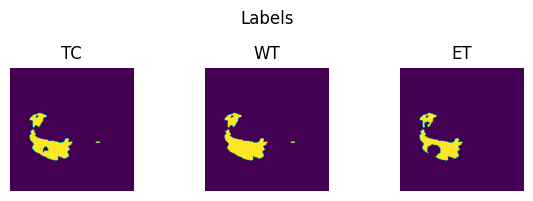

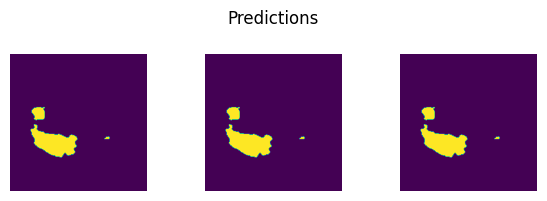

VAL
   Batch 1/31, val_loss: 0.8806
   Batch 2/31, val_loss: 0.9992
   Batch 3/31, val_loss: 0.9965
   Batch 4/31, val_loss: 0.9923
   Batch 5/31, val_loss: 0.9998
   Batch 6/31, val_loss: 0.7385
   Batch 7/31, val_loss: 0.8600
   Batch 8/31, val_loss: 0.9823
   Batch 9/31, val_loss: 0.7279
   Batch 10/31, val_loss: 0.9615
   Batch 11/31, val_loss: 0.8495
   Batch 12/31, val_loss: 0.9767
   Batch 13/31, val_loss: 0.9857
   Batch 14/31, val_loss: 0.9700
   Batch 15/31, val_loss: 0.9947
   Batch 16/31, val_loss: 0.9912
   Batch 17/31, val_loss: 0.9994
   Batch 18/31, val_loss: 0.9830
   Batch 19/31, val_loss: 0.7747
   Batch 20/31, val_loss: 0.8825
   Batch 21/31, val_loss: 0.9246
   Batch 22/31, val_loss: 0.9976
   Batch 23/31, val_loss: 0.9891
   Batch 24/31, val_loss: 0.7501
   Batch 25/31, val_loss: 0.8186
   Batch 26/31, val_loss: 0.9495
   Batch 27/31, val_loss: 0.9983
   Batch 28/31, val_loss: 0.7850
   Batch 29/31, val_loss: 0.9975
   Batch 30/31, val_loss: 0.9766
   Batch 31/31,

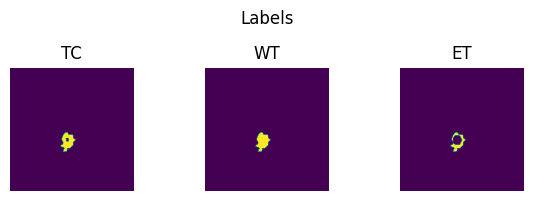

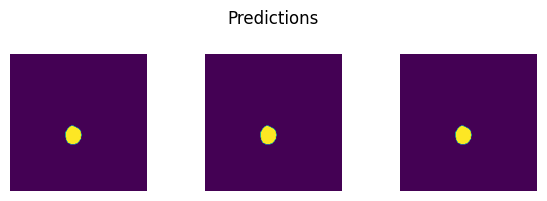

epoch 64
   average train loss: 0.5951
   average validation loss: 0.9266
   saved as best model: True
   current mean dice: 0.3107
   current TC dice: 0.3254
   current WT dice: 0.3317
   current ET dice: 0.3042
Best Mean Metric: 0.3107
time consuming of epoch 64 is: 1389.6312
----------
epoch 65/100
TRAIN
   Batch 1/248, train_loss: 0.1101, step time: 0.3849
   Batch 2/248, train_loss: 0.9992, step time: 0.3523
   Batch 3/248, train_loss: 0.9300, step time: 0.3743
   Batch 4/248, train_loss: 0.9993, step time: 0.3513
   Batch 5/248, train_loss: 0.7358, step time: 0.3683
   Batch 6/248, train_loss: 0.6726, step time: 0.3581
   Batch 7/248, train_loss: 0.1211, step time: 0.3634
   Batch 8/248, train_loss: 0.7516, step time: 0.3558
   Batch 9/248, train_loss: 0.0772, step time: 0.3409
   Batch 10/248, train_loss: 0.8714, step time: 0.3564
   Batch 11/248, train_loss: 0.6845, step time: 0.3459
   Batch 12/248, train_loss: 0.9842, step time: 0.3468
   Batch 13/248, train_loss: 0.9428, ste

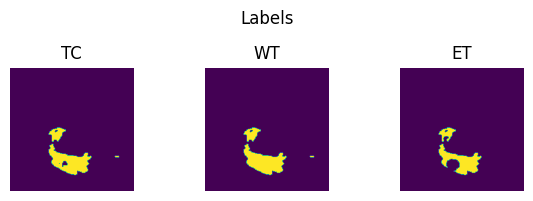

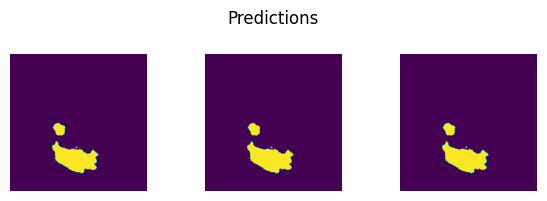

VAL
   Batch 1/31, val_loss: 0.8704
   Batch 2/31, val_loss: 0.9996
   Batch 3/31, val_loss: 0.9978
   Batch 4/31, val_loss: 0.9921
   Batch 5/31, val_loss: 0.9998
   Batch 6/31, val_loss: 0.7525
   Batch 7/31, val_loss: 0.8558
   Batch 8/31, val_loss: 0.9802
   Batch 9/31, val_loss: 0.7412
   Batch 10/31, val_loss: 0.9691
   Batch 11/31, val_loss: 0.8556
   Batch 12/31, val_loss: 0.9784
   Batch 13/31, val_loss: 0.9922
   Batch 14/31, val_loss: 0.9732
   Batch 15/31, val_loss: 0.9999
   Batch 16/31, val_loss: 0.9847
   Batch 17/31, val_loss: 0.9997
   Batch 18/31, val_loss: 0.9855
   Batch 19/31, val_loss: 0.7898
   Batch 20/31, val_loss: 0.8834
   Batch 21/31, val_loss: 0.9335
   Batch 22/31, val_loss: 0.9985
   Batch 23/31, val_loss: 0.9918
   Batch 24/31, val_loss: 0.7506
   Batch 25/31, val_loss: 0.8209
   Batch 26/31, val_loss: 0.9491
   Batch 27/31, val_loss: 0.9986
   Batch 28/31, val_loss: 0.7869
   Batch 29/31, val_loss: 0.9974
   Batch 30/31, val_loss: 0.9988
   Batch 31/31,

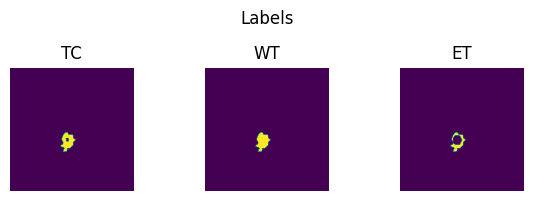

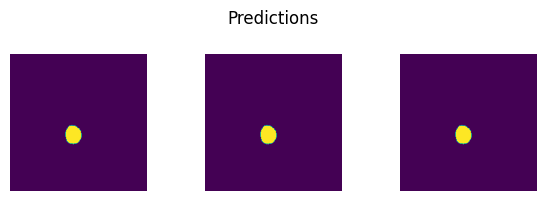

epoch 65
   average train loss: 0.5920
   average validation loss: 0.9297
   saved as best model: False
   current mean dice: 0.3088
   current TC dice: 0.3230
   current WT dice: 0.3289
   current ET dice: 0.3039
Best Mean Metric: 0.3107
time consuming of epoch 65 is: 1385.8502
----------
epoch 66/100
TRAIN
   Batch 1/248, train_loss: 0.1330, step time: 0.3429
   Batch 2/248, train_loss: 0.9999, step time: 0.3791
   Batch 3/248, train_loss: 0.9286, step time: 0.3618
   Batch 4/248, train_loss: 0.9997, step time: 0.3741
   Batch 5/248, train_loss: 0.7035, step time: 0.3794
   Batch 6/248, train_loss: 0.7098, step time: 0.3568
   Batch 7/248, train_loss: 0.1162, step time: 0.3380
   Batch 8/248, train_loss: 0.7465, step time: 0.3519
   Batch 9/248, train_loss: 0.0760, step time: 0.3727
   Batch 10/248, train_loss: 0.8524, step time: 0.3692
   Batch 11/248, train_loss: 0.6645, step time: 0.3753
   Batch 12/248, train_loss: 0.9993, step time: 0.3652
   Batch 13/248, train_loss: 0.9304, st

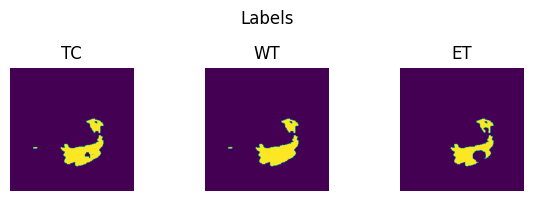

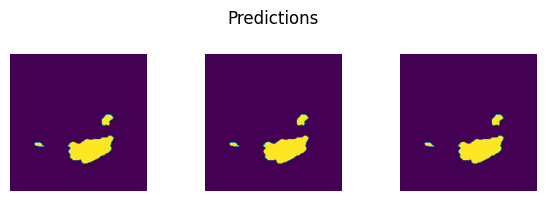

VAL
   Batch 1/31, val_loss: 0.8777
   Batch 2/31, val_loss: 0.9996
   Batch 3/31, val_loss: 0.9940
   Batch 4/31, val_loss: 0.9920
   Batch 5/31, val_loss: 0.9998
   Batch 6/31, val_loss: 0.7400
   Batch 7/31, val_loss: 0.8564
   Batch 8/31, val_loss: 0.9816
   Batch 9/31, val_loss: 0.7289
   Batch 10/31, val_loss: 0.9759
   Batch 11/31, val_loss: 0.8554
   Batch 12/31, val_loss: 0.9757
   Batch 13/31, val_loss: 0.9883
   Batch 14/31, val_loss: 0.9700
   Batch 15/31, val_loss: 0.9999
   Batch 16/31, val_loss: 0.9876
   Batch 17/31, val_loss: 0.9992
   Batch 18/31, val_loss: 0.9847
   Batch 19/31, val_loss: 0.7896
   Batch 20/31, val_loss: 0.8790
   Batch 21/31, val_loss: 0.9278
   Batch 22/31, val_loss: 0.9986
   Batch 23/31, val_loss: 0.9903
   Batch 24/31, val_loss: 0.7424
   Batch 25/31, val_loss: 0.8177
   Batch 26/31, val_loss: 0.9491
   Batch 27/31, val_loss: 0.9976
   Batch 28/31, val_loss: 0.7813
   Batch 29/31, val_loss: 0.9952
   Batch 30/31, val_loss: 0.9931
   Batch 31/31,

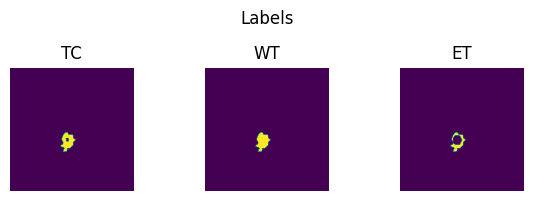

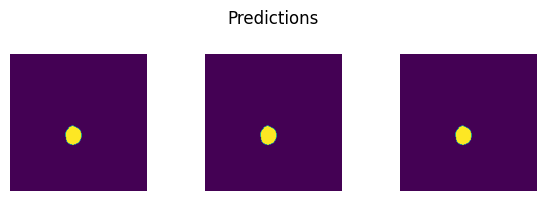

epoch 66
   average train loss: 0.5876
   average validation loss: 0.9278
   saved as best model: False
   current mean dice: 0.3104
   current TC dice: 0.3246
   current WT dice: 0.3306
   current ET dice: 0.3054
Best Mean Metric: 0.3107
time consuming of epoch 66 is: 1387.4231
----------
epoch 67/100
TRAIN
   Batch 1/248, train_loss: 0.1284, step time: 0.3730
   Batch 2/248, train_loss: 0.9975, step time: 0.3494
   Batch 3/248, train_loss: 0.9221, step time: 0.3688
   Batch 4/248, train_loss: 0.9993, step time: 0.3718
   Batch 5/248, train_loss: 0.6988, step time: 0.3395
   Batch 6/248, train_loss: 0.7178, step time: 0.3413
   Batch 7/248, train_loss: 0.1167, step time: 0.3563
   Batch 8/248, train_loss: 0.7504, step time: 0.3658
   Batch 9/248, train_loss: 0.0723, step time: 0.3455
   Batch 10/248, train_loss: 0.8470, step time: 0.3787
   Batch 11/248, train_loss: 0.6489, step time: 0.3677
   Batch 12/248, train_loss: 0.9983, step time: 0.3495
   Batch 13/248, train_loss: 0.9239, st

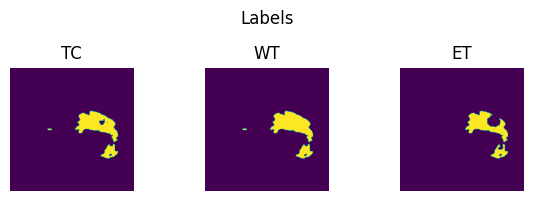

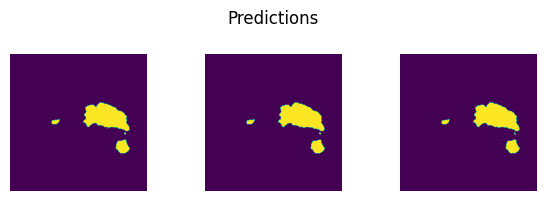

VAL
   Batch 1/31, val_loss: 0.8797
   Batch 2/31, val_loss: 0.9978
   Batch 3/31, val_loss: 0.9896
   Batch 4/31, val_loss: 0.9917
   Batch 5/31, val_loss: 0.9997
   Batch 6/31, val_loss: 0.7386
   Batch 7/31, val_loss: 0.8543
   Batch 8/31, val_loss: 0.9797
   Batch 9/31, val_loss: 0.7238
   Batch 10/31, val_loss: 0.9708
   Batch 11/31, val_loss: 0.8486
   Batch 12/31, val_loss: 0.9748
   Batch 13/31, val_loss: 0.9799
   Batch 14/31, val_loss: 0.9674
   Batch 15/31, val_loss: 0.9925
   Batch 16/31, val_loss: 0.9819
   Batch 17/31, val_loss: 0.9967
   Batch 18/31, val_loss: 0.9809
   Batch 19/31, val_loss: 0.7770
   Batch 20/31, val_loss: 0.8813
   Batch 21/31, val_loss: 0.9232
   Batch 22/31, val_loss: 0.9981
   Batch 23/31, val_loss: 0.9838
   Batch 24/31, val_loss: 0.7461
   Batch 25/31, val_loss: 0.8177
   Batch 26/31, val_loss: 0.9477
   Batch 27/31, val_loss: 0.9962
   Batch 28/31, val_loss: 0.7831
   Batch 29/31, val_loss: 0.9933
   Batch 30/31, val_loss: 0.9973
   Batch 31/31,

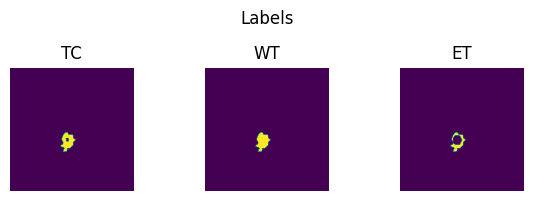

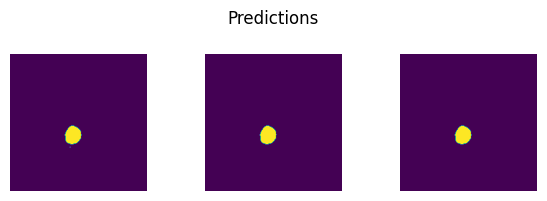

epoch 67
   average train loss: 0.5879
   average validation loss: 0.9254
   saved as best model: True
   current mean dice: 0.3151
   current TC dice: 0.3301
   current WT dice: 0.3364
   current ET dice: 0.3086
Best Mean Metric: 0.3151
time consuming of epoch 67 is: 1389.6466
----------
epoch 68/100
TRAIN
   Batch 1/248, train_loss: 0.1250, step time: 0.3573
   Batch 2/248, train_loss: 0.9986, step time: 0.3804
   Batch 3/248, train_loss: 0.9195, step time: 0.3546
   Batch 4/248, train_loss: 0.9996, step time: 0.3722
   Batch 5/248, train_loss: 0.7103, step time: 0.3469
   Batch 6/248, train_loss: 0.7122, step time: 0.3468
   Batch 7/248, train_loss: 0.1150, step time: 0.3558
   Batch 8/248, train_loss: 0.7514, step time: 0.3820
   Batch 9/248, train_loss: 0.0749, step time: 0.3772
   Batch 10/248, train_loss: 0.8459, step time: 0.3432
   Batch 11/248, train_loss: 0.6346, step time: 0.3591
   Batch 12/248, train_loss: 0.9857, step time: 0.3567
   Batch 13/248, train_loss: 0.9367, ste

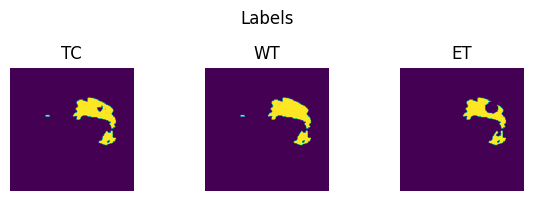

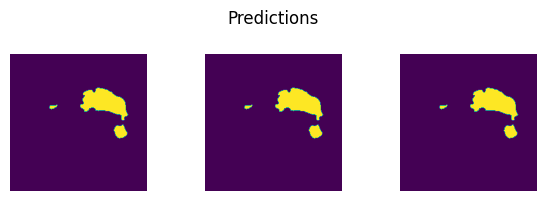

VAL
   Batch 1/31, val_loss: 0.8780
   Batch 2/31, val_loss: 0.9995
   Batch 3/31, val_loss: 0.9961
   Batch 4/31, val_loss: 0.9919
   Batch 5/31, val_loss: 0.9998
   Batch 6/31, val_loss: 0.7251
   Batch 7/31, val_loss: 0.8560
   Batch 8/31, val_loss: 0.9851
   Batch 9/31, val_loss: 0.7299
   Batch 10/31, val_loss: 0.9712
   Batch 11/31, val_loss: 0.8462
   Batch 12/31, val_loss: 0.9759
   Batch 13/31, val_loss: 0.9874
   Batch 14/31, val_loss: 0.9711
   Batch 15/31, val_loss: 0.9984
   Batch 16/31, val_loss: 0.9897
   Batch 17/31, val_loss: 0.9979
   Batch 18/31, val_loss: 0.9837
   Batch 19/31, val_loss: 0.7835
   Batch 20/31, val_loss: 0.8823
   Batch 21/31, val_loss: 0.9200
   Batch 22/31, val_loss: 0.9988
   Batch 23/31, val_loss: 0.9901
   Batch 24/31, val_loss: 0.7462
   Batch 25/31, val_loss: 0.8161
   Batch 26/31, val_loss: 0.9476
   Batch 27/31, val_loss: 0.9980
   Batch 28/31, val_loss: 0.7804
   Batch 29/31, val_loss: 0.9982
   Batch 30/31, val_loss: 0.9947
   Batch 31/31,

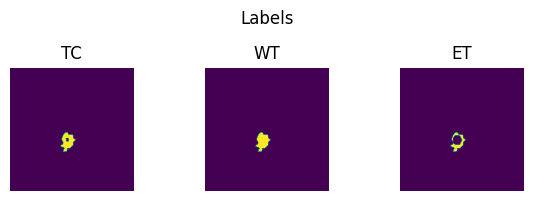

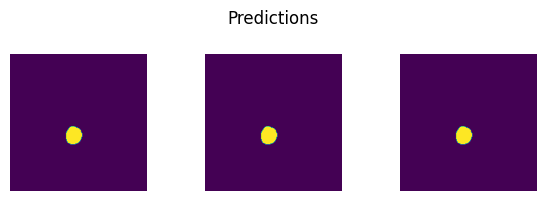

epoch 68
   average train loss: 0.5791
   average validation loss: 0.9268
   saved as best model: True
   current mean dice: 0.3167
   current TC dice: 0.3321
   current WT dice: 0.3385
   current ET dice: 0.3092
Best Mean Metric: 0.3167
time consuming of epoch 68 is: 1396.6251
----------
epoch 69/100
TRAIN
   Batch 1/248, train_loss: 0.1145, step time: 0.3475
   Batch 2/248, train_loss: 0.9975, step time: 0.3700
   Batch 3/248, train_loss: 0.9214, step time: 0.3773
   Batch 4/248, train_loss: 0.9999, step time: 0.3788
   Batch 5/248, train_loss: 0.6902, step time: 0.3642
   Batch 6/248, train_loss: 0.6744, step time: 0.3485
   Batch 7/248, train_loss: 0.1220, step time: 0.3684
   Batch 8/248, train_loss: 0.7477, step time: 0.3473
   Batch 9/248, train_loss: 0.0769, step time: 0.3685
   Batch 10/248, train_loss: 0.8385, step time: 0.3402
   Batch 11/248, train_loss: 0.6414, step time: 0.3617
   Batch 12/248, train_loss: 0.9986, step time: 0.3640
   Batch 13/248, train_loss: 0.9040, ste

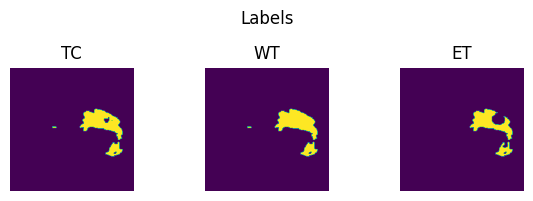

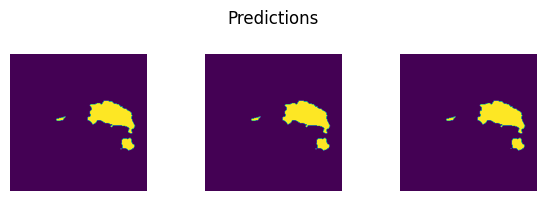

VAL
   Batch 1/31, val_loss: 0.8785
   Batch 2/31, val_loss: 0.9997
   Batch 3/31, val_loss: 0.9963
   Batch 4/31, val_loss: 0.9911
   Batch 5/31, val_loss: 0.9998
   Batch 6/31, val_loss: 0.7264
   Batch 7/31, val_loss: 0.8556
   Batch 8/31, val_loss: 0.9792
   Batch 9/31, val_loss: 0.7321
   Batch 10/31, val_loss: 0.9651
   Batch 11/31, val_loss: 0.8510
   Batch 12/31, val_loss: 0.9755
   Batch 13/31, val_loss: 0.9941
   Batch 14/31, val_loss: 0.9716
   Batch 15/31, val_loss: 0.9950
   Batch 16/31, val_loss: 0.9901
   Batch 17/31, val_loss: 0.9970
   Batch 18/31, val_loss: 0.9784
   Batch 19/31, val_loss: 0.7864
   Batch 20/31, val_loss: 0.8873
   Batch 21/31, val_loss: 0.9208
   Batch 22/31, val_loss: 0.9981
   Batch 23/31, val_loss: 0.9893
   Batch 24/31, val_loss: 0.7459
   Batch 25/31, val_loss: 0.8177
   Batch 26/31, val_loss: 0.9481
   Batch 27/31, val_loss: 0.9980
   Batch 28/31, val_loss: 0.7772
   Batch 29/31, val_loss: 0.9951
   Batch 30/31, val_loss: 0.9914
   Batch 31/31,

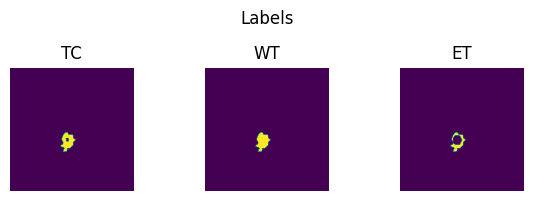

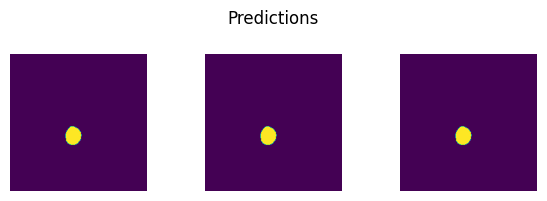

epoch 69
   average train loss: 0.5777
   average validation loss: 0.9266
   saved as best model: True
   current mean dice: 0.3187
   current TC dice: 0.3341
   current WT dice: 0.3406
   current ET dice: 0.3113
Best Mean Metric: 0.3187
time consuming of epoch 69 is: 1399.2357
----------
epoch 70/100
TRAIN
   Batch 1/248, train_loss: 0.1107, step time: 0.3485
   Batch 2/248, train_loss: 0.9962, step time: 0.3505
   Batch 3/248, train_loss: 0.9085, step time: 0.3568
   Batch 4/248, train_loss: 0.9996, step time: 0.3753
   Batch 5/248, train_loss: 0.6772, step time: 0.3747
   Batch 6/248, train_loss: 0.6297, step time: 0.3841
   Batch 7/248, train_loss: 0.1129, step time: 0.3556
   Batch 8/248, train_loss: 0.7514, step time: 0.3797
   Batch 9/248, train_loss: 0.0717, step time: 0.3395
   Batch 10/248, train_loss: 0.8314, step time: 0.3585
   Batch 11/248, train_loss: 0.6171, step time: 0.3722
   Batch 12/248, train_loss: 0.9912, step time: 0.3657
   Batch 13/248, train_loss: 0.9263, ste

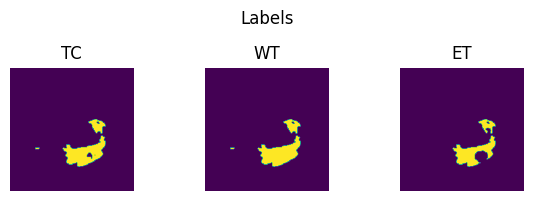

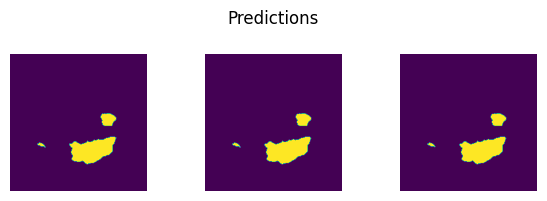

VAL
   Batch 1/31, val_loss: 0.8848
   Batch 2/31, val_loss: 0.9996
   Batch 3/31, val_loss: 0.9946
   Batch 4/31, val_loss: 0.9915
   Batch 5/31, val_loss: 0.9998
   Batch 6/31, val_loss: 0.7003
   Batch 7/31, val_loss: 0.8637
   Batch 8/31, val_loss: 0.9855
   Batch 9/31, val_loss: 0.7224
   Batch 10/31, val_loss: 0.9689
   Batch 11/31, val_loss: 0.8491
   Batch 12/31, val_loss: 0.9783
   Batch 13/31, val_loss: 0.9938
   Batch 14/31, val_loss: 0.9701
   Batch 15/31, val_loss: 0.9999
   Batch 16/31, val_loss: 0.9878
   Batch 17/31, val_loss: 0.9945
   Batch 18/31, val_loss: 0.9827
   Batch 19/31, val_loss: 0.7867
   Batch 20/31, val_loss: 0.8772
   Batch 21/31, val_loss: 0.9183
   Batch 22/31, val_loss: 0.9980
   Batch 23/31, val_loss: 0.9935
   Batch 24/31, val_loss: 0.6973
   Batch 25/31, val_loss: 0.8178
   Batch 26/31, val_loss: 0.9451
   Batch 27/31, val_loss: 0.9986
   Batch 28/31, val_loss: 0.7821
   Batch 29/31, val_loss: 0.9952
   Batch 30/31, val_loss: 0.9901
   Batch 31/31,

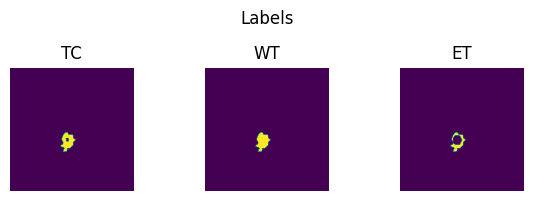

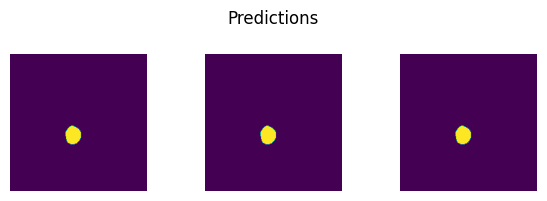

epoch 70
   average train loss: 0.5742
   average validation loss: 0.9245
   saved as best model: True
   current mean dice: 0.3216
   current TC dice: 0.3367
   current WT dice: 0.3432
   current ET dice: 0.3155
Best Mean Metric: 0.3216
time consuming of epoch 70 is: 1399.0902
----------
epoch 71/100
TRAIN
   Batch 1/248, train_loss: 0.1149, step time: 0.3592
   Batch 2/248, train_loss: 0.9999, step time: 0.3567
   Batch 3/248, train_loss: 0.9111, step time: 0.3408
   Batch 4/248, train_loss: 0.9987, step time: 0.3810
   Batch 5/248, train_loss: 0.6559, step time: 0.3759
   Batch 6/248, train_loss: 0.6510, step time: 0.3804
   Batch 7/248, train_loss: 0.1161, step time: 0.3633
   Batch 8/248, train_loss: 0.7517, step time: 0.3475
   Batch 9/248, train_loss: 0.0716, step time: 0.3819
   Batch 10/248, train_loss: 0.8276, step time: 0.3413
   Batch 11/248, train_loss: 0.6072, step time: 0.3438
   Batch 12/248, train_loss: 0.9881, step time: 0.3567
   Batch 13/248, train_loss: 0.9200, ste

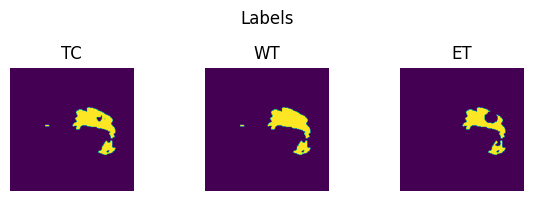

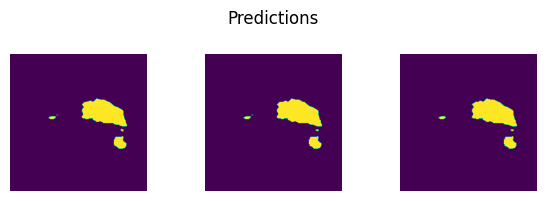

VAL
   Batch 1/31, val_loss: 0.8772
   Batch 2/31, val_loss: 0.9996
   Batch 3/31, val_loss: 0.9949
   Batch 4/31, val_loss: 0.9911
   Batch 5/31, val_loss: 0.9998
   Batch 6/31, val_loss: 0.7255
   Batch 7/31, val_loss: 0.8541
   Batch 8/31, val_loss: 0.9816
   Batch 9/31, val_loss: 0.7332
   Batch 10/31, val_loss: 0.9655
   Batch 11/31, val_loss: 0.8536
   Batch 12/31, val_loss: 0.9760
   Batch 13/31, val_loss: 0.9812
   Batch 14/31, val_loss: 0.9680
   Batch 15/31, val_loss: 0.9998
   Batch 16/31, val_loss: 0.9905
   Batch 17/31, val_loss: 0.9968
   Batch 18/31, val_loss: 0.9798
   Batch 19/31, val_loss: 0.7770
   Batch 20/31, val_loss: 0.8737
   Batch 21/31, val_loss: 0.9203
   Batch 22/31, val_loss: 0.9993
   Batch 23/31, val_loss: 0.9874
   Batch 24/31, val_loss: 0.7256
   Batch 25/31, val_loss: 0.8168
   Batch 26/31, val_loss: 0.9464
   Batch 27/31, val_loss: 0.9918
   Batch 28/31, val_loss: 0.7778
   Batch 29/31, val_loss: 0.9946
   Batch 30/31, val_loss: 0.9910
   Batch 31/31,

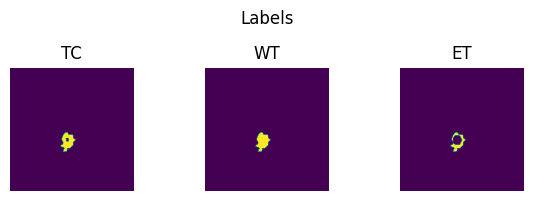

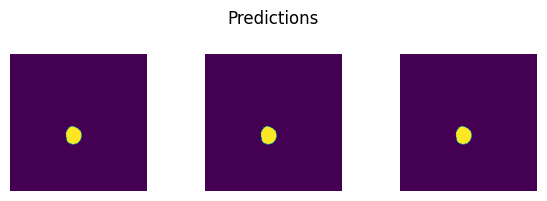

epoch 71
   average train loss: 0.5698
   average validation loss: 0.9246
   saved as best model: False
   current mean dice: 0.3214
   current TC dice: 0.3373
   current WT dice: 0.3438
   current ET dice: 0.3135
Best Mean Metric: 0.3216
time consuming of epoch 71 is: 1365.9350
----------
epoch 72/100
TRAIN
   Batch 1/248, train_loss: 0.1129, step time: 0.3389
   Batch 2/248, train_loss: 0.9947, step time: 0.3478
   Batch 3/248, train_loss: 0.9107, step time: 0.3544
   Batch 4/248, train_loss: 0.9997, step time: 0.3535
   Batch 5/248, train_loss: 0.6625, step time: 0.3420
   Batch 6/248, train_loss: 0.6274, step time: 0.3423
   Batch 7/248, train_loss: 0.1245, step time: 0.3721
   Batch 8/248, train_loss: 0.7589, step time: 0.3417
   Batch 9/248, train_loss: 0.0687, step time: 0.3807
   Batch 10/248, train_loss: 0.8168, step time: 0.3555
   Batch 11/248, train_loss: 0.5910, step time: 0.3473
   Batch 12/248, train_loss: 0.9902, step time: 0.3681
   Batch 13/248, train_loss: 0.9189, st

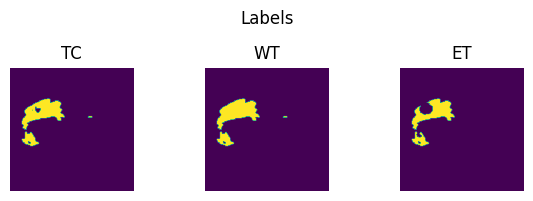

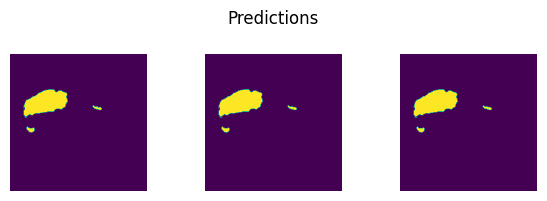

VAL
   Batch 1/31, val_loss: 0.8741
   Batch 2/31, val_loss: 0.9996
   Batch 3/31, val_loss: 0.9937
   Batch 4/31, val_loss: 0.9915
   Batch 5/31, val_loss: 0.9998
   Batch 6/31, val_loss: 0.7349
   Batch 7/31, val_loss: 0.8532
   Batch 8/31, val_loss: 0.9925
   Batch 9/31, val_loss: 0.7391
   Batch 10/31, val_loss: 0.9732
   Batch 11/31, val_loss: 0.8597
   Batch 12/31, val_loss: 0.9760
   Batch 13/31, val_loss: 0.9902
   Batch 14/31, val_loss: 0.9709
   Batch 15/31, val_loss: 0.9999
   Batch 16/31, val_loss: 0.9833
   Batch 17/31, val_loss: 0.9968
   Batch 18/31, val_loss: 0.9807
   Batch 19/31, val_loss: 0.8003
   Batch 20/31, val_loss: 0.8747
   Batch 21/31, val_loss: 0.9205
   Batch 22/31, val_loss: 0.9995
   Batch 23/31, val_loss: 0.9917
   Batch 24/31, val_loss: 0.6977
   Batch 25/31, val_loss: 0.8170
   Batch 26/31, val_loss: 0.9439
   Batch 27/31, val_loss: 0.9943
   Batch 28/31, val_loss: 0.7795
   Batch 29/31, val_loss: 0.9985
   Batch 30/31, val_loss: 0.9918
   Batch 31/31,

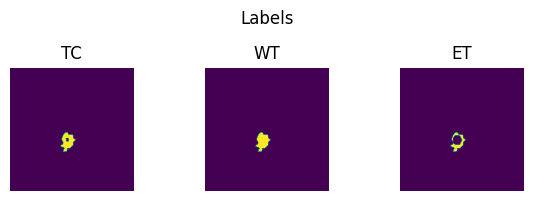

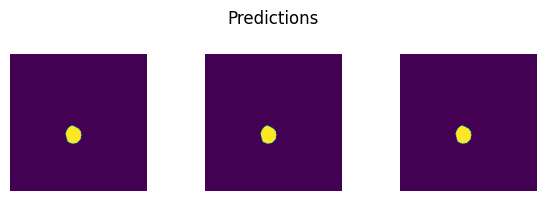

epoch 72
   average train loss: 0.5646
   average validation loss: 0.9262
   saved as best model: False
   current mean dice: 0.3211
   current TC dice: 0.3371
   current WT dice: 0.3435
   current ET dice: 0.3129
Best Mean Metric: 0.3216
time consuming of epoch 72 is: 1403.2395
----------
epoch 73/100
TRAIN
   Batch 1/248, train_loss: 0.1218, step time: 0.3792
   Batch 2/248, train_loss: 1.0000, step time: 0.3394
   Batch 3/248, train_loss: 0.9140, step time: 0.3740
   Batch 4/248, train_loss: 1.0000, step time: 0.3465
   Batch 5/248, train_loss: 0.6834, step time: 0.3730
   Batch 6/248, train_loss: 0.6890, step time: 0.3792
   Batch 7/248, train_loss: 0.1133, step time: 0.3809
   Batch 8/248, train_loss: 0.7558, step time: 0.3584
   Batch 9/248, train_loss: 0.0701, step time: 0.3410
   Batch 10/248, train_loss: 0.8126, step time: 0.3516
   Batch 11/248, train_loss: 0.5770, step time: 0.3393
   Batch 12/248, train_loss: 0.9977, step time: 0.3679
   Batch 13/248, train_loss: 0.9256, st

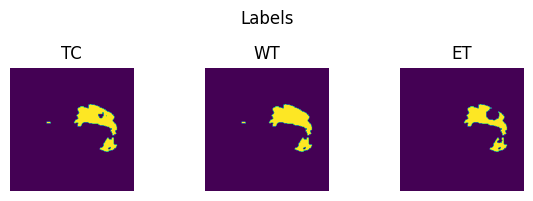

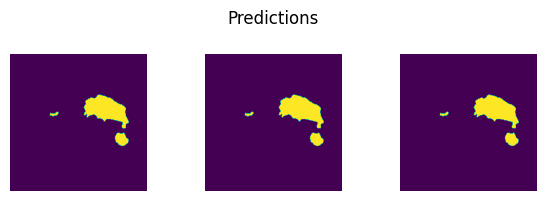

VAL
   Batch 1/31, val_loss: 0.8749
   Batch 2/31, val_loss: 0.9976
   Batch 3/31, val_loss: 0.9911
   Batch 4/31, val_loss: 0.9907
   Batch 5/31, val_loss: 0.9998
   Batch 6/31, val_loss: 0.7310
   Batch 7/31, val_loss: 0.8517
   Batch 8/31, val_loss: 0.9612
   Batch 9/31, val_loss: 0.7221
   Batch 10/31, val_loss: 0.9632
   Batch 11/31, val_loss: 0.8432
   Batch 12/31, val_loss: 0.9739
   Batch 13/31, val_loss: 0.9873
   Batch 14/31, val_loss: 0.9694
   Batch 15/31, val_loss: 0.9992
   Batch 16/31, val_loss: 0.9900
   Batch 17/31, val_loss: 0.9971
   Batch 18/31, val_loss: 0.9782
   Batch 19/31, val_loss: 0.7809
   Batch 20/31, val_loss: 0.8735
   Batch 21/31, val_loss: 0.9157
   Batch 22/31, val_loss: 0.9984
   Batch 23/31, val_loss: 0.9857
   Batch 24/31, val_loss: 0.7060
   Batch 25/31, val_loss: 0.8164
   Batch 26/31, val_loss: 0.9424
   Batch 27/31, val_loss: 0.9892
   Batch 28/31, val_loss: 0.7831
   Batch 29/31, val_loss: 0.9952
   Batch 30/31, val_loss: 0.9967
   Batch 31/31,

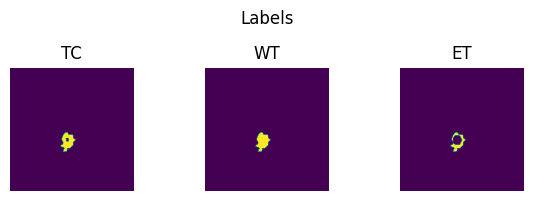

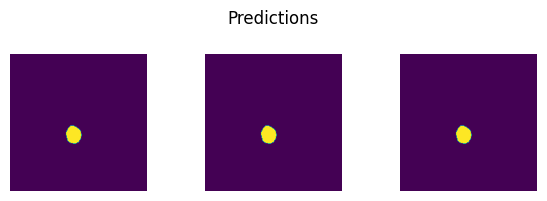

epoch 73
   average train loss: 0.5635
   average validation loss: 0.9225
   saved as best model: True
   current mean dice: 0.3232
   current TC dice: 0.3393
   current WT dice: 0.3460
   current ET dice: 0.3143
Best Mean Metric: 0.3232
time consuming of epoch 73 is: 1374.8788
----------
epoch 74/100
TRAIN
   Batch 1/248, train_loss: 0.1171, step time: 0.3458
   Batch 2/248, train_loss: 0.9991, step time: 0.3815
   Batch 3/248, train_loss: 0.9150, step time: 0.3456
   Batch 4/248, train_loss: 0.9996, step time: 0.3817
   Batch 5/248, train_loss: 0.6548, step time: 0.3882
   Batch 6/248, train_loss: 0.6450, step time: 0.3904
   Batch 7/248, train_loss: 0.1169, step time: 0.3440
   Batch 8/248, train_loss: 0.7399, step time: 0.3787
   Batch 9/248, train_loss: 0.0732, step time: 0.3842
   Batch 10/248, train_loss: 0.8159, step time: 0.3836
   Batch 11/248, train_loss: 0.5741, step time: 0.3707
   Batch 12/248, train_loss: 0.9939, step time: 0.3836
   Batch 13/248, train_loss: 0.9127, ste

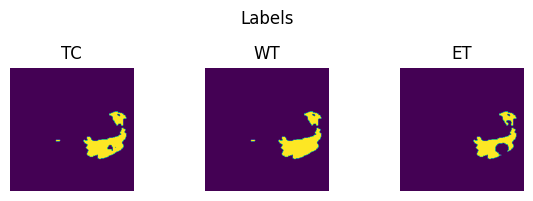

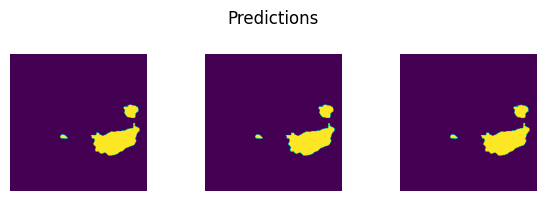

VAL
   Batch 1/31, val_loss: 0.8771
   Batch 2/31, val_loss: 0.9973
   Batch 3/31, val_loss: 0.9923
   Batch 4/31, val_loss: 0.9912
   Batch 5/31, val_loss: 0.9998
   Batch 6/31, val_loss: 0.6839
   Batch 7/31, val_loss: 0.8598
   Batch 8/31, val_loss: 0.9790
   Batch 9/31, val_loss: 0.7206
   Batch 10/31, val_loss: 0.9661
   Batch 11/31, val_loss: 0.8514
   Batch 12/31, val_loss: 0.9748
   Batch 13/31, val_loss: 0.9785
   Batch 14/31, val_loss: 0.9713
   Batch 15/31, val_loss: 0.9999
   Batch 16/31, val_loss: 0.9900
   Batch 17/31, val_loss: 0.9896
   Batch 18/31, val_loss: 0.9792
   Batch 19/31, val_loss: 0.7821
   Batch 20/31, val_loss: 0.8739
   Batch 21/31, val_loss: 0.9173
   Batch 22/31, val_loss: 0.9987
   Batch 23/31, val_loss: 0.9875
   Batch 24/31, val_loss: 0.5518
   Batch 25/31, val_loss: 0.8201
   Batch 26/31, val_loss: 0.9428
   Batch 27/31, val_loss: 0.9906
   Batch 28/31, val_loss: 0.7791
   Batch 29/31, val_loss: 0.9923
   Batch 30/31, val_loss: 0.9942
   Batch 31/31,

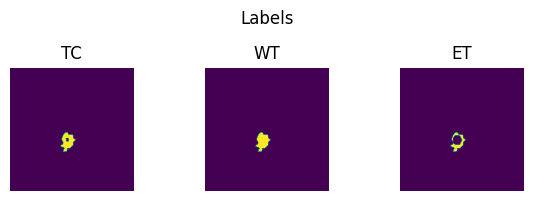

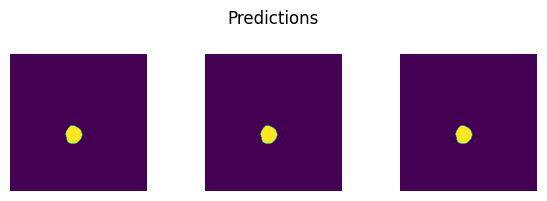

epoch 74
   average train loss: 0.5570
   average validation loss: 0.9169
   saved as best model: False
   current mean dice: 0.3203
   current TC dice: 0.3364
   current WT dice: 0.3431
   current ET dice: 0.3111
Best Mean Metric: 0.3232
time consuming of epoch 74 is: 1390.2619
----------
epoch 75/100
TRAIN
   Batch 1/248, train_loss: 0.1324, step time: 0.3460
   Batch 2/248, train_loss: 0.9980, step time: 0.3874
   Batch 3/248, train_loss: 0.9011, step time: 0.3894
   Batch 4/248, train_loss: 0.9986, step time: 0.3477
   Batch 5/248, train_loss: 0.7052, step time: 0.3481
   Batch 6/248, train_loss: 0.6834, step time: 0.3659
   Batch 7/248, train_loss: 0.1099, step time: 0.3684
   Batch 8/248, train_loss: 0.7538, step time: 0.3609
   Batch 9/248, train_loss: 0.0707, step time: 0.3845
   Batch 10/248, train_loss: 0.7995, step time: 0.3472
   Batch 11/248, train_loss: 0.5787, step time: 0.3440
   Batch 12/248, train_loss: 0.9892, step time: 0.3601
   Batch 13/248, train_loss: 0.8995, st

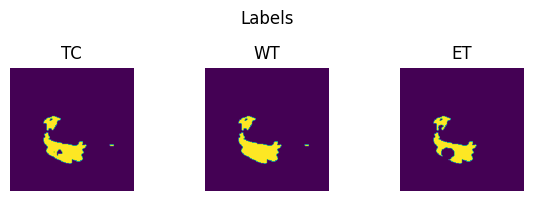

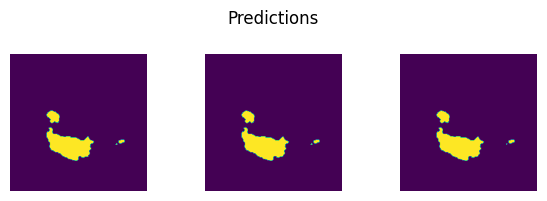

VAL
   Batch 1/31, val_loss: 0.8758
   Batch 2/31, val_loss: 0.9968
   Batch 3/31, val_loss: 0.9931
   Batch 4/31, val_loss: 0.9892
   Batch 5/31, val_loss: 0.9998
   Batch 6/31, val_loss: 0.7115
   Batch 7/31, val_loss: 0.8514
   Batch 8/31, val_loss: 0.9775
   Batch 9/31, val_loss: 0.7238
   Batch 10/31, val_loss: 0.9532
   Batch 11/31, val_loss: 0.8373
   Batch 12/31, val_loss: 0.9739
   Batch 13/31, val_loss: 0.9839
   Batch 14/31, val_loss: 0.9687
   Batch 15/31, val_loss: 0.9958
   Batch 16/31, val_loss: 0.9898
   Batch 17/31, val_loss: 0.9918
   Batch 18/31, val_loss: 0.9753
   Batch 19/31, val_loss: 0.7736
   Batch 20/31, val_loss: 0.8964
   Batch 21/31, val_loss: 0.9134
   Batch 22/31, val_loss: 0.9970
   Batch 23/31, val_loss: 0.9832
   Batch 24/31, val_loss: 0.6317
   Batch 25/31, val_loss: 0.8141
   Batch 26/31, val_loss: 0.9401
   Batch 27/31, val_loss: 0.9910
   Batch 28/31, val_loss: 0.7782
   Batch 29/31, val_loss: 0.9954
   Batch 30/31, val_loss: 0.9927
   Batch 31/31,

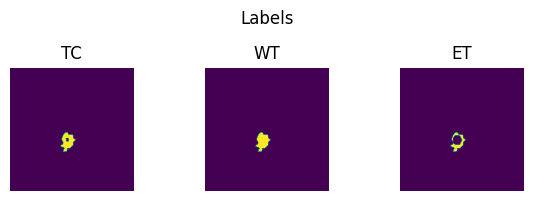

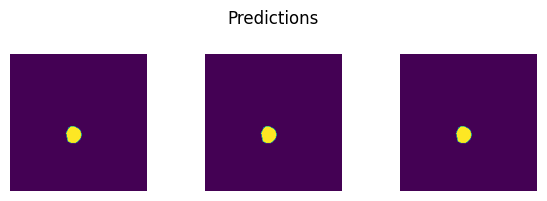

epoch 75
   average train loss: 0.5532
   average validation loss: 0.9189
   saved as best model: True
   current mean dice: 0.3306
   current TC dice: 0.3484
   current WT dice: 0.3553
   current ET dice: 0.3186
Best Mean Metric: 0.3306
time consuming of epoch 75 is: 1406.3692
----------
epoch 76/100
TRAIN
   Batch 1/248, train_loss: 0.1086, step time: 0.3851
   Batch 2/248, train_loss: 0.9953, step time: 0.3533
   Batch 3/248, train_loss: 0.8882, step time: 0.3439
   Batch 4/248, train_loss: 0.9998, step time: 0.3606
   Batch 5/248, train_loss: 0.6332, step time: 0.3831
   Batch 6/248, train_loss: 0.6836, step time: 0.3802
   Batch 7/248, train_loss: 0.1085, step time: 0.3789
   Batch 8/248, train_loss: 0.7301, step time: 0.3738
   Batch 9/248, train_loss: 0.0670, step time: 0.3625
   Batch 10/248, train_loss: 0.7950, step time: 0.3724
   Batch 11/248, train_loss: 0.5327, step time: 0.3595
   Batch 12/248, train_loss: 0.9897, step time: 0.3423
   Batch 13/248, train_loss: 0.9026, ste

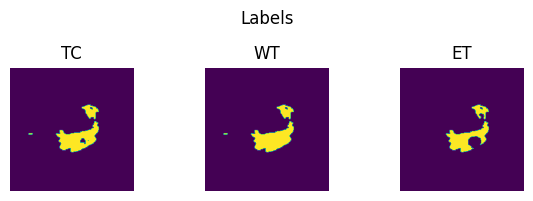

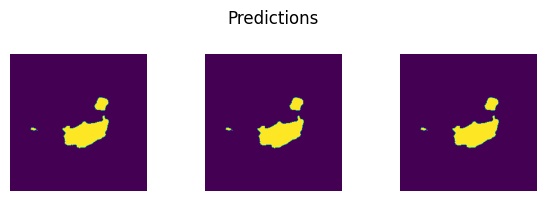

VAL
   Batch 1/31, val_loss: 0.8772
   Batch 2/31, val_loss: 0.9995
   Batch 3/31, val_loss: 0.9927
   Batch 4/31, val_loss: 0.9898
   Batch 5/31, val_loss: 0.9997
   Batch 6/31, val_loss: 0.7054
   Batch 7/31, val_loss: 0.8551
   Batch 8/31, val_loss: 0.9736
   Batch 9/31, val_loss: 0.7315
   Batch 10/31, val_loss: 0.9637
   Batch 11/31, val_loss: 0.8411
   Batch 12/31, val_loss: 0.9752
   Batch 13/31, val_loss: 0.9903
   Batch 14/31, val_loss: 0.9692
   Batch 15/31, val_loss: 0.9979
   Batch 16/31, val_loss: 0.9829
   Batch 17/31, val_loss: 0.9954
   Batch 18/31, val_loss: 0.9726
   Batch 19/31, val_loss: 0.7878
   Batch 20/31, val_loss: 0.8862
   Batch 21/31, val_loss: 0.9149
   Batch 22/31, val_loss: 0.9973
   Batch 23/31, val_loss: 0.9879
   Batch 24/31, val_loss: 0.5305
   Batch 25/31, val_loss: 0.8175
   Batch 26/31, val_loss: 0.9406
   Batch 27/31, val_loss: 0.9952
   Batch 28/31, val_loss: 0.7803
   Batch 29/31, val_loss: 0.9922
   Batch 30/31, val_loss: 0.9883
   Batch 31/31,

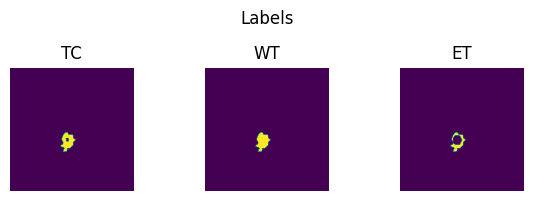

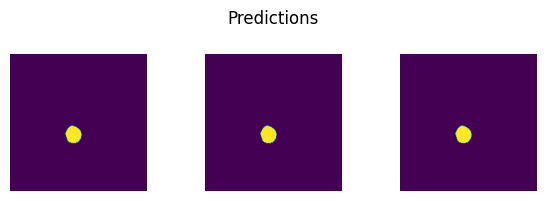

epoch 76
   average train loss: 0.5463
   average validation loss: 0.9169
   saved as best model: True
   current mean dice: 0.3309
   current TC dice: 0.3481
   current WT dice: 0.3551
   current ET dice: 0.3204
Best Mean Metric: 0.3309
time consuming of epoch 76 is: 1423.0018
----------
epoch 77/100
TRAIN
   Batch 1/248, train_loss: 0.1287, step time: 0.3713
   Batch 2/248, train_loss: 0.9999, step time: 0.3449
   Batch 3/248, train_loss: 0.8922, step time: 0.3814
   Batch 4/248, train_loss: 0.9983, step time: 0.3697
   Batch 5/248, train_loss: 0.5932, step time: 0.3775
   Batch 6/248, train_loss: 0.6314, step time: 0.3421
   Batch 7/248, train_loss: 0.1026, step time: 0.3798
   Batch 8/248, train_loss: 0.7363, step time: 0.3427
   Batch 9/248, train_loss: 0.0698, step time: 0.3779
   Batch 10/248, train_loss: 0.7772, step time: 0.3688
   Batch 11/248, train_loss: 0.5138, step time: 0.3410
   Batch 12/248, train_loss: 0.9873, step time: 0.3800
   Batch 13/248, train_loss: 0.8783, ste

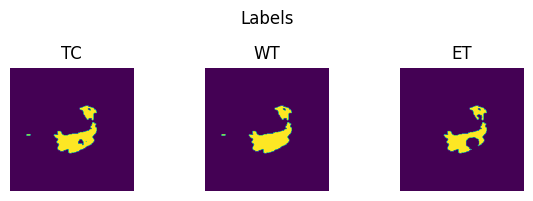

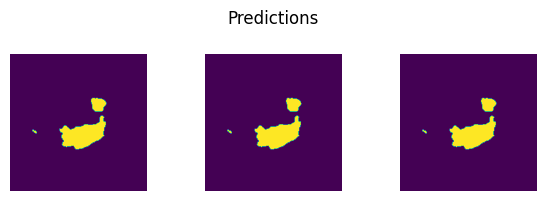

VAL
   Batch 1/31, val_loss: 0.8791
   Batch 2/31, val_loss: 0.9998
   Batch 3/31, val_loss: 0.9855
   Batch 4/31, val_loss: 0.9886
   Batch 5/31, val_loss: 0.9997
   Batch 6/31, val_loss: 0.5564
   Batch 7/31, val_loss: 0.8585
   Batch 8/31, val_loss: 0.9837
   Batch 9/31, val_loss: 0.7049
   Batch 10/31, val_loss: 0.9623
   Batch 11/31, val_loss: 0.8425
   Batch 12/31, val_loss: 0.9760
   Batch 13/31, val_loss: 0.9816
   Batch 14/31, val_loss: 0.9692
   Batch 15/31, val_loss: 0.9998
   Batch 16/31, val_loss: 0.9876
   Batch 17/31, val_loss: 0.9960
   Batch 18/31, val_loss: 0.9747
   Batch 19/31, val_loss: 0.7780
   Batch 20/31, val_loss: 0.8770
   Batch 21/31, val_loss: 0.9101
   Batch 22/31, val_loss: 0.9980
   Batch 23/31, val_loss: 0.9905
   Batch 24/31, val_loss: 0.3272
   Batch 25/31, val_loss: 0.8205
   Batch 26/31, val_loss: 0.9380
   Batch 27/31, val_loss: 0.9962
   Batch 28/31, val_loss: 0.7743
   Batch 29/31, val_loss: 0.9939
   Batch 30/31, val_loss: 0.9933
   Batch 31/31,

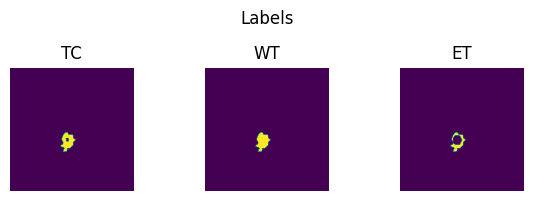

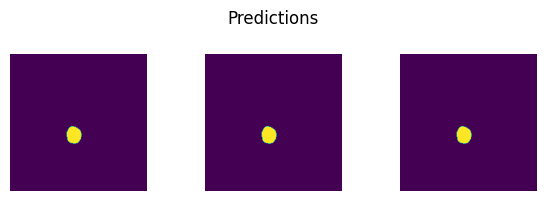

epoch 77
   average train loss: 0.5338
   average validation loss: 0.9043
   saved as best model: False
   current mean dice: 0.3309
   current TC dice: 0.3480
   current WT dice: 0.3552
   current ET dice: 0.3204
Best Mean Metric: 0.3309
time consuming of epoch 77 is: 1412.7025
----------
epoch 78/100
TRAIN
   Batch 1/248, train_loss: 0.1192, step time: 0.3632
   Batch 2/248, train_loss: 0.9988, step time: 0.3539
   Batch 3/248, train_loss: 0.8604, step time: 0.3708
   Batch 4/248, train_loss: 0.9999, step time: 0.3702
   Batch 5/248, train_loss: 0.5677, step time: 0.3819
   Batch 6/248, train_loss: 0.7167, step time: 0.3651
   Batch 7/248, train_loss: 0.1115, step time: 0.3750
   Batch 8/248, train_loss: 0.7513, step time: 0.3511
   Batch 9/248, train_loss: 0.0691, step time: 0.3569
   Batch 10/248, train_loss: 0.7360, step time: 0.3755
   Batch 11/248, train_loss: 0.4895, step time: 0.3524
   Batch 12/248, train_loss: 0.9869, step time: 0.3702
   Batch 13/248, train_loss: 0.9155, st

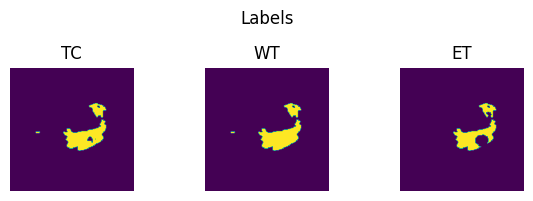

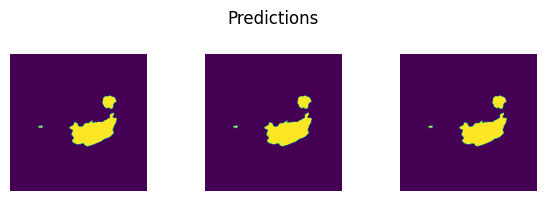

VAL
   Batch 1/31, val_loss: 0.8766
   Batch 2/31, val_loss: 0.9988
   Batch 3/31, val_loss: 0.9943
   Batch 4/31, val_loss: 0.9863
   Batch 5/31, val_loss: 0.9997
   Batch 6/31, val_loss: 0.5592
   Batch 7/31, val_loss: 0.8596
   Batch 8/31, val_loss: 0.9851
   Batch 9/31, val_loss: 0.6883
   Batch 10/31, val_loss: 0.9620
   Batch 11/31, val_loss: 0.8519
   Batch 12/31, val_loss: 0.9798
   Batch 13/31, val_loss: 0.9774
   Batch 14/31, val_loss: 0.9705
   Batch 15/31, val_loss: 0.9999
   Batch 16/31, val_loss: 0.9893
   Batch 17/31, val_loss: 0.9954
   Batch 18/31, val_loss: 0.9761
   Batch 19/31, val_loss: 0.7917
   Batch 20/31, val_loss: 0.8955
   Batch 21/31, val_loss: 0.9111
   Batch 22/31, val_loss: 0.9995
   Batch 23/31, val_loss: 0.9958
   Batch 24/31, val_loss: 0.3410
   Batch 25/31, val_loss: 0.8250
   Batch 26/31, val_loss: 0.9362
   Batch 27/31, val_loss: 0.9941
   Batch 28/31, val_loss: 0.7766
   Batch 29/31, val_loss: 0.9940
   Batch 30/31, val_loss: 0.9927
   Batch 31/31,

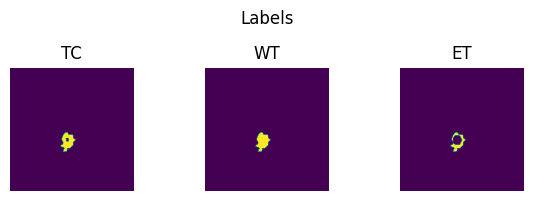

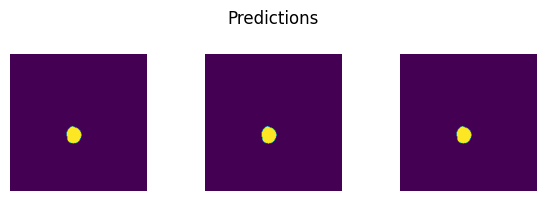

epoch 78
   average train loss: 0.5252
   average validation loss: 0.9062
   saved as best model: True
   current mean dice: 0.3406
   current TC dice: 0.3588
   current WT dice: 0.3661
   current ET dice: 0.3286
Best Mean Metric: 0.3406
time consuming of epoch 78 is: 1414.6981
----------
epoch 79/100
TRAIN
   Batch 1/248, train_loss: 0.1151, step time: 0.3870
   Batch 2/248, train_loss: 0.9992, step time: 0.3418
   Batch 3/248, train_loss: 0.8452, step time: 0.3875
   Batch 4/248, train_loss: 1.0000, step time: 0.3431
   Batch 5/248, train_loss: 0.5960, step time: 0.3877
   Batch 6/248, train_loss: 0.6652, step time: 0.3706
   Batch 7/248, train_loss: 0.1189, step time: 0.3705
   Batch 8/248, train_loss: 0.7375, step time: 0.3453
   Batch 9/248, train_loss: 0.0701, step time: 0.3696
   Batch 10/248, train_loss: 0.6956, step time: 0.3446
   Batch 11/248, train_loss: 0.4199, step time: 0.3477
   Batch 12/248, train_loss: 0.9971, step time: 0.3881
   Batch 13/248, train_loss: 0.8580, ste

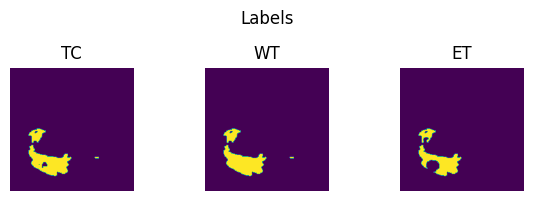

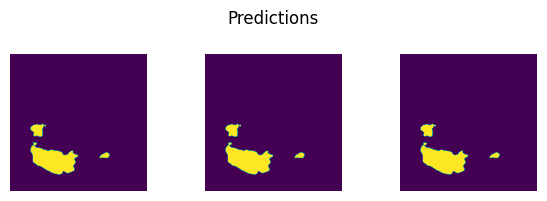

VAL
   Batch 1/31, val_loss: 0.8690
   Batch 2/31, val_loss: 0.9994
   Batch 3/31, val_loss: 0.9916
   Batch 4/31, val_loss: 0.9860
   Batch 5/31, val_loss: 0.9998
   Batch 6/31, val_loss: 0.3517
   Batch 7/31, val_loss: 0.8575
   Batch 8/31, val_loss: 0.9788
   Batch 9/31, val_loss: 0.5693
   Batch 10/31, val_loss: 0.9552
   Batch 11/31, val_loss: 0.8556
   Batch 12/31, val_loss: 0.9763
   Batch 13/31, val_loss: 0.9776
   Batch 14/31, val_loss: 0.9704
   Batch 15/31, val_loss: 0.9978
   Batch 16/31, val_loss: 0.9907
   Batch 17/31, val_loss: 0.9949
   Batch 18/31, val_loss: 0.9753
   Batch 19/31, val_loss: 0.7511
   Batch 20/31, val_loss: 0.8875
   Batch 21/31, val_loss: 0.9147
   Batch 22/31, val_loss: 0.9974
   Batch 23/31, val_loss: 0.9901
   Batch 24/31, val_loss: 0.1786
   Batch 25/31, val_loss: 0.8121
   Batch 26/31, val_loss: 0.9377
   Batch 27/31, val_loss: 0.9879
   Batch 28/31, val_loss: 0.7700
   Batch 29/31, val_loss: 0.9920
   Batch 30/31, val_loss: 0.9885
   Batch 31/31,

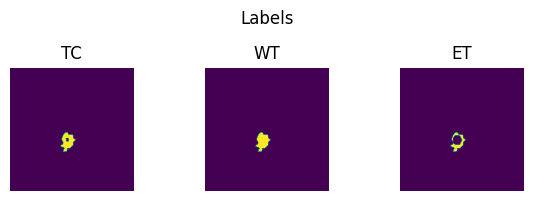

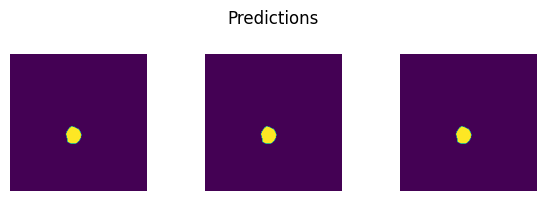

epoch 79
   average train loss: 0.5160
   average validation loss: 0.8869
   saved as best model: False
   current mean dice: 0.3401
   current TC dice: 0.3583
   current WT dice: 0.3656
   current ET dice: 0.3279
Best Mean Metric: 0.3406
time consuming of epoch 79 is: 1412.0388
----------
epoch 80/100
TRAIN
   Batch 1/248, train_loss: 0.1207, step time: 0.3466
   Batch 2/248, train_loss: 0.9985, step time: 0.3731
   Batch 3/248, train_loss: 0.8297, step time: 0.3595
   Batch 4/248, train_loss: 1.0000, step time: 0.3872
   Batch 5/248, train_loss: 0.5463, step time: 0.3640
   Batch 6/248, train_loss: 0.6762, step time: 0.3747
   Batch 7/248, train_loss: 0.1094, step time: 0.3488
   Batch 8/248, train_loss: 0.7547, step time: 0.3882
   Batch 9/248, train_loss: 0.0669, step time: 0.3646
   Batch 10/248, train_loss: 0.6612, step time: 0.3493
   Batch 11/248, train_loss: 0.4017, step time: 0.3531
   Batch 12/248, train_loss: 0.9805, step time: 0.3663
   Batch 13/248, train_loss: 0.8613, st

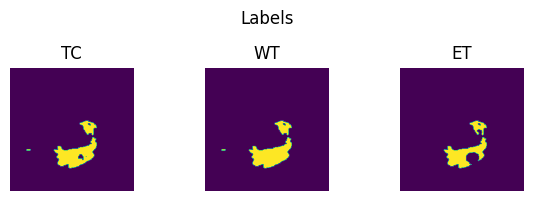

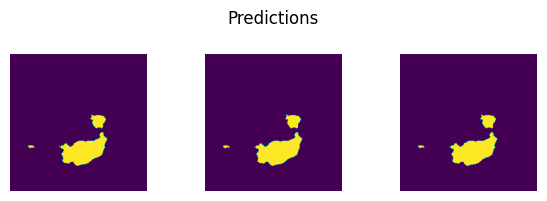

VAL
   Batch 1/31, val_loss: 0.8418
   Batch 2/31, val_loss: 0.9982
   Batch 3/31, val_loss: 0.9939
   Batch 4/31, val_loss: 0.9833
   Batch 5/31, val_loss: 0.9998
   Batch 6/31, val_loss: 0.2625
   Batch 7/31, val_loss: 0.8463
   Batch 8/31, val_loss: 0.9834
   Batch 9/31, val_loss: 0.4463
   Batch 10/31, val_loss: 0.9612
   Batch 11/31, val_loss: 0.8580
   Batch 12/31, val_loss: 0.9795
   Batch 13/31, val_loss: 0.9814
   Batch 14/31, val_loss: 0.9710
   Batch 15/31, val_loss: 0.9977
   Batch 16/31, val_loss: 0.9905
   Batch 17/31, val_loss: 0.9981
   Batch 18/31, val_loss: 0.9734
   Batch 19/31, val_loss: 0.7240
   Batch 20/31, val_loss: 0.8842
   Batch 21/31, val_loss: 0.9266
   Batch 22/31, val_loss: 0.9989
   Batch 23/31, val_loss: 0.9888
   Batch 24/31, val_loss: 0.0860
   Batch 25/31, val_loss: 0.8061
   Batch 26/31, val_loss: 0.9380
   Batch 27/31, val_loss: 0.9992
   Batch 28/31, val_loss: 0.7646
   Batch 29/31, val_loss: 0.9997
   Batch 30/31, val_loss: 0.9904
   Batch 31/31,

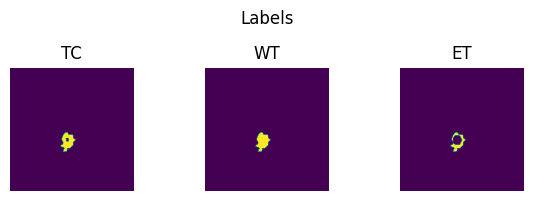

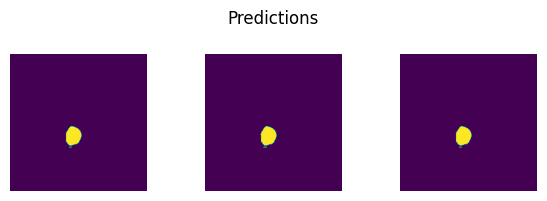

epoch 80
   average train loss: 0.5102
   average validation loss: 0.8762
   saved as best model: False
   current mean dice: 0.3313
   current TC dice: 0.3477
   current WT dice: 0.3551
   current ET dice: 0.3224
Best Mean Metric: 0.3406
time consuming of epoch 80 is: 1413.4240
----------
epoch 81/100
TRAIN
   Batch 1/248, train_loss: 0.1294, step time: 0.3677
   Batch 2/248, train_loss: 1.0000, step time: 0.3832
   Batch 3/248, train_loss: 0.8324, step time: 0.3646
   Batch 4/248, train_loss: 0.9999, step time: 0.3425
   Batch 5/248, train_loss: 0.5063, step time: 0.3721
   Batch 6/248, train_loss: 0.6812, step time: 0.3596
   Batch 7/248, train_loss: 0.1175, step time: 0.3605
   Batch 8/248, train_loss: 0.7534, step time: 0.3807
   Batch 9/248, train_loss: 0.0721, step time: 0.3628
   Batch 10/248, train_loss: 0.6265, step time: 0.3775
   Batch 11/248, train_loss: 0.3559, step time: 0.3497
   Batch 12/248, train_loss: 0.9662, step time: 0.3561
   Batch 13/248, train_loss: 0.8829, st

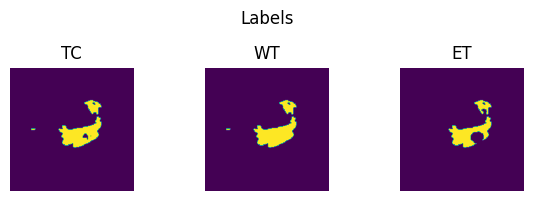

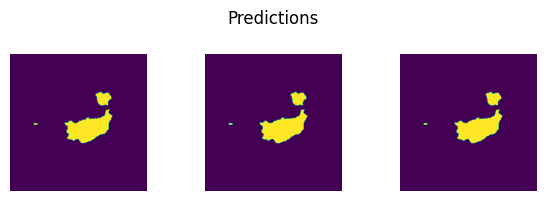

VAL
   Batch 1/31, val_loss: 0.8587
   Batch 2/31, val_loss: 0.9987
   Batch 3/31, val_loss: 0.9932
   Batch 4/31, val_loss: 0.9834
   Batch 5/31, val_loss: 0.9996
   Batch 6/31, val_loss: 0.2192
   Batch 7/31, val_loss: 0.8366
   Batch 8/31, val_loss: 0.9734
   Batch 9/31, val_loss: 0.3428
   Batch 10/31, val_loss: 0.9372
   Batch 11/31, val_loss: 0.8465
   Batch 12/31, val_loss: 0.9775
   Batch 13/31, val_loss: 0.9758
   Batch 14/31, val_loss: 0.9669
   Batch 15/31, val_loss: 0.9967
   Batch 16/31, val_loss: 0.9894
   Batch 17/31, val_loss: 0.9955
   Batch 18/31, val_loss: 0.9674
   Batch 19/31, val_loss: 0.6626
   Batch 20/31, val_loss: 0.8789
   Batch 21/31, val_loss: 0.9123
   Batch 22/31, val_loss: 0.9993
   Batch 23/31, val_loss: 0.9784
   Batch 24/31, val_loss: 0.0741
   Batch 25/31, val_loss: 0.7851
   Batch 26/31, val_loss: 0.9391
   Batch 27/31, val_loss: 0.9965
   Batch 28/31, val_loss: 0.7602
   Batch 29/31, val_loss: 0.9926
   Batch 30/31, val_loss: 0.9797
   Batch 31/31,

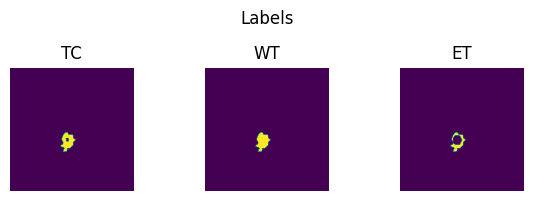

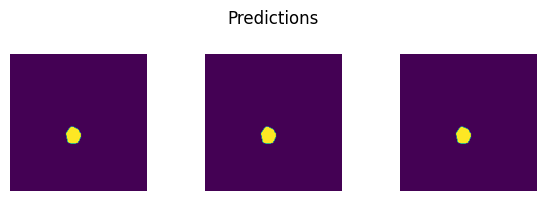

epoch 81
   average train loss: 0.4899
   average validation loss: 0.8647
   saved as best model: True
   current mean dice: 0.3546
   current TC dice: 0.3738
   current WT dice: 0.3813
   current ET dice: 0.3415
Best Mean Metric: 0.3546
time consuming of epoch 81 is: 1408.4300
----------
epoch 82/100
TRAIN
   Batch 1/248, train_loss: 0.1271, step time: 0.3763
   Batch 2/248, train_loss: 0.9995, step time: 0.3444
   Batch 3/248, train_loss: 0.8088, step time: 0.3439
   Batch 4/248, train_loss: 1.0000, step time: 0.3433
   Batch 5/248, train_loss: 0.4556, step time: 0.3605
   Batch 6/248, train_loss: 0.6705, step time: 0.3894
   Batch 7/248, train_loss: 0.1147, step time: 0.3505
   Batch 8/248, train_loss: 0.7551, step time: 0.3781
   Batch 9/248, train_loss: 0.0703, step time: 0.3709
   Batch 10/248, train_loss: 0.6051, step time: 0.3570
   Batch 11/248, train_loss: 0.4003, step time: 0.3580
   Batch 12/248, train_loss: 0.9909, step time: 0.3915
   Batch 13/248, train_loss: 0.8208, ste

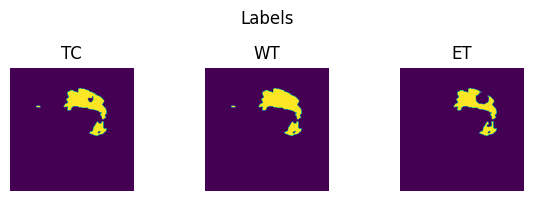

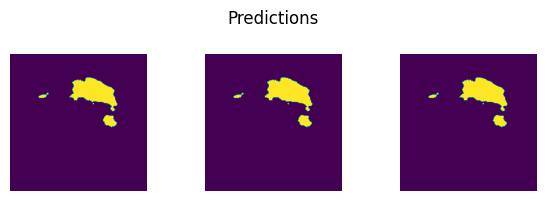

VAL
   Batch 1/31, val_loss: 0.8596
   Batch 2/31, val_loss: 0.9947
   Batch 3/31, val_loss: 0.9925
   Batch 4/31, val_loss: 0.9822
   Batch 5/31, val_loss: 0.9993
   Batch 6/31, val_loss: 0.1597
   Batch 7/31, val_loss: 0.8158
   Batch 8/31, val_loss: 0.9751
   Batch 9/31, val_loss: 0.2774
   Batch 10/31, val_loss: 0.9460
   Batch 11/31, val_loss: 0.8418
   Batch 12/31, val_loss: 0.9732
   Batch 13/31, val_loss: 0.9867
   Batch 14/31, val_loss: 0.9614
   Batch 15/31, val_loss: 0.9998
   Batch 16/31, val_loss: 0.9800
   Batch 17/31, val_loss: 0.9927
   Batch 18/31, val_loss: 0.9668
   Batch 19/31, val_loss: 0.5456
   Batch 20/31, val_loss: 0.8898
   Batch 21/31, val_loss: 0.9210
   Batch 22/31, val_loss: 0.9982
   Batch 23/31, val_loss: 0.9717
   Batch 24/31, val_loss: 0.0584
   Batch 25/31, val_loss: 0.7442
   Batch 26/31, val_loss: 0.9367
   Batch 27/31, val_loss: 0.9940
   Batch 28/31, val_loss: 0.7291
   Batch 29/31, val_loss: 0.9904
   Batch 30/31, val_loss: 0.9834
   Batch 31/31,

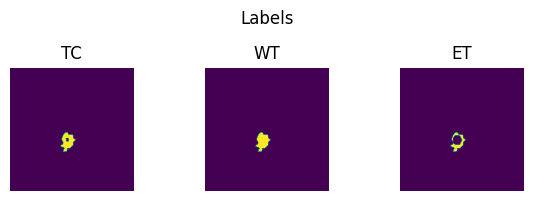

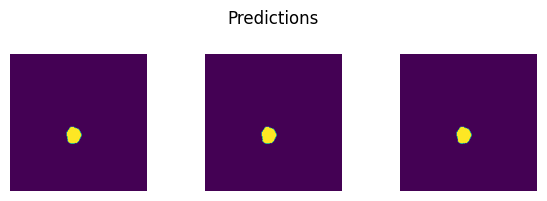

epoch 82
   average train loss: 0.4870
   average validation loss: 0.8533
   saved as best model: True
   current mean dice: 0.3678
   current TC dice: 0.3865
   current WT dice: 0.3944
   current ET dice: 0.3565
Best Mean Metric: 0.3678
time consuming of epoch 82 is: 1421.0814
----------
epoch 83/100
TRAIN
   Batch 1/248, train_loss: 0.1144, step time: 0.3574
   Batch 2/248, train_loss: 0.9999, step time: 0.3459
   Batch 3/248, train_loss: 0.7833, step time: 0.3565
   Batch 4/248, train_loss: 0.9999, step time: 0.3819
   Batch 5/248, train_loss: 0.3980, step time: 0.3850
   Batch 6/248, train_loss: 0.6449, step time: 0.3617
   Batch 7/248, train_loss: 0.1104, step time: 0.3453
   Batch 8/248, train_loss: 0.7546, step time: 0.3423
   Batch 9/248, train_loss: 0.0666, step time: 0.3860
   Batch 10/248, train_loss: 0.5966, step time: 0.3755
   Batch 11/248, train_loss: 0.3998, step time: 0.3463
   Batch 12/248, train_loss: 0.9978, step time: 0.3837
   Batch 13/248, train_loss: 0.8187, ste

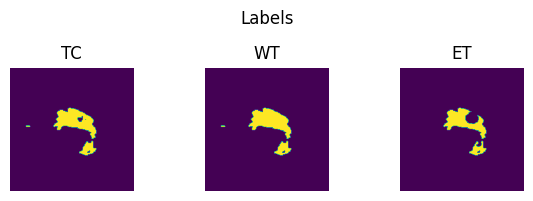

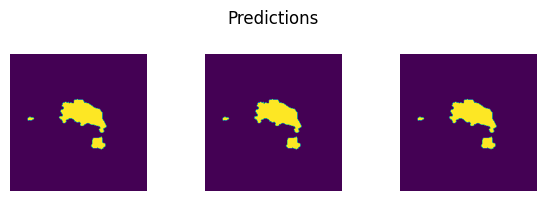

VAL
   Batch 1/31, val_loss: 0.8509
   Batch 2/31, val_loss: 0.9957
   Batch 3/31, val_loss: 0.9912
   Batch 4/31, val_loss: 0.9787
   Batch 5/31, val_loss: 0.9991
   Batch 6/31, val_loss: 0.1817
   Batch 7/31, val_loss: 0.8021
   Batch 8/31, val_loss: 0.9728
   Batch 9/31, val_loss: 0.2007
   Batch 10/31, val_loss: 0.9298
   Batch 11/31, val_loss: 0.8288
   Batch 12/31, val_loss: 0.9676
   Batch 13/31, val_loss: 0.9676
   Batch 14/31, val_loss: 0.9477
   Batch 15/31, val_loss: 0.9920
   Batch 16/31, val_loss: 0.9856
   Batch 17/31, val_loss: 0.9933
   Batch 18/31, val_loss: 0.9627
   Batch 19/31, val_loss: 0.4834
   Batch 20/31, val_loss: 0.8808
   Batch 21/31, val_loss: 0.9097
   Batch 22/31, val_loss: 0.9960
   Batch 23/31, val_loss: 0.9567
   Batch 24/31, val_loss: 0.0613
   Batch 25/31, val_loss: 0.7187
   Batch 26/31, val_loss: 0.9398
   Batch 27/31, val_loss: 0.9966
   Batch 28/31, val_loss: 0.7209
   Batch 29/31, val_loss: 0.9919
   Batch 30/31, val_loss: 0.9816
   Batch 31/31,

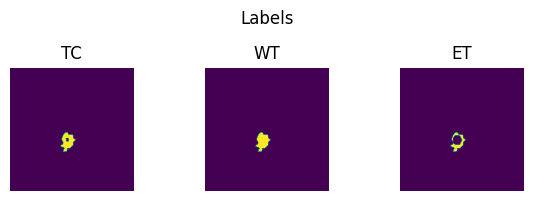

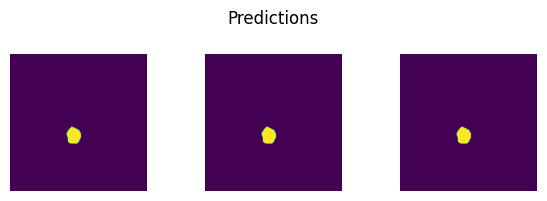

epoch 83
   average train loss: 0.4852
   average validation loss: 0.8442
   saved as best model: False
   current mean dice: 0.3627
   current TC dice: 0.3833
   current WT dice: 0.3912
   current ET dice: 0.3470
Best Mean Metric: 0.3678
time consuming of epoch 83 is: 1422.8908
----------
epoch 84/100
TRAIN
   Batch 1/248, train_loss: 0.1095, step time: 0.3474
   Batch 2/248, train_loss: 0.9910, step time: 0.3825
   Batch 3/248, train_loss: 0.7334, step time: 0.3916
   Batch 4/248, train_loss: 0.9992, step time: 0.3813
   Batch 5/248, train_loss: 0.4480, step time: 0.3819
   Batch 6/248, train_loss: 0.5747, step time: 0.3527
   Batch 7/248, train_loss: 0.1061, step time: 0.3625
   Batch 8/248, train_loss: 0.7302, step time: 0.3565
   Batch 9/248, train_loss: 0.0651, step time: 0.3699
   Batch 10/248, train_loss: 0.5629, step time: 0.3461
   Batch 11/248, train_loss: 0.3756, step time: 0.3837
   Batch 12/248, train_loss: 0.9593, step time: 0.3811
   Batch 13/248, train_loss: 0.8610, st

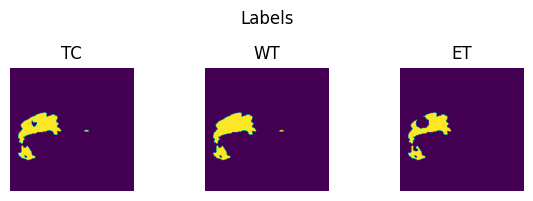

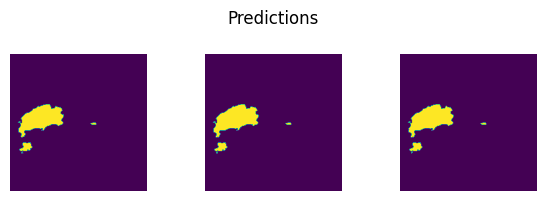

VAL
   Batch 1/31, val_loss: 0.8116
   Batch 2/31, val_loss: 0.9904
   Batch 3/31, val_loss: 0.9866
   Batch 4/31, val_loss: 0.9769
   Batch 5/31, val_loss: 0.9984
   Batch 6/31, val_loss: 0.1604
   Batch 7/31, val_loss: 0.7734
   Batch 8/31, val_loss: 0.9736
   Batch 9/31, val_loss: 0.1804
   Batch 10/31, val_loss: 0.9316
   Batch 11/31, val_loss: 0.8280
   Batch 12/31, val_loss: 0.9595
   Batch 13/31, val_loss: 0.9660
   Batch 14/31, val_loss: 0.9094
   Batch 15/31, val_loss: 0.9994
   Batch 16/31, val_loss: 0.9749
   Batch 17/31, val_loss: 0.9817
   Batch 18/31, val_loss: 0.9561
   Batch 19/31, val_loss: 0.4438
   Batch 20/31, val_loss: 0.8661
   Batch 21/31, val_loss: 0.9124
   Batch 22/31, val_loss: 0.9933
   Batch 23/31, val_loss: 0.9262
   Batch 24/31, val_loss: 0.0577
   Batch 25/31, val_loss: 0.6963
   Batch 26/31, val_loss: 0.9340
   Batch 27/31, val_loss: 0.9887
   Batch 28/31, val_loss: 0.6386
   Batch 29/31, val_loss: 0.9908
   Batch 30/31, val_loss: 0.9697
   Batch 31/31,

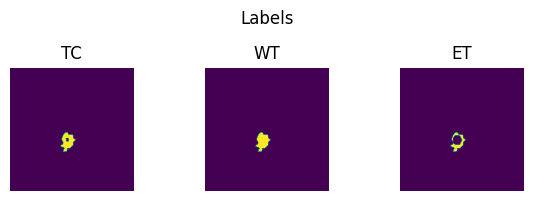

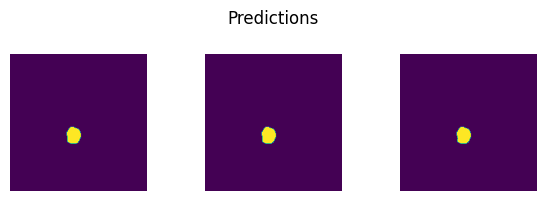

epoch 84
   average train loss: 0.4866
   average validation loss: 0.8310
   saved as best model: True
   current mean dice: 0.3710
   current TC dice: 0.3913
   current WT dice: 0.3990
   current ET dice: 0.3568
Best Mean Metric: 0.3710
time consuming of epoch 84 is: 1435.2000
----------
epoch 85/100
TRAIN
   Batch 1/248, train_loss: 0.1391, step time: 0.3612
   Batch 2/248, train_loss: 0.9946, step time: 0.3695
   Batch 3/248, train_loss: 0.7568, step time: 0.3523
   Batch 4/248, train_loss: 0.9999, step time: 0.3777
   Batch 5/248, train_loss: 0.4333, step time: 0.3558
   Batch 6/248, train_loss: 0.6247, step time: 0.3601
   Batch 7/248, train_loss: 0.1044, step time: 0.3654
   Batch 8/248, train_loss: 0.7518, step time: 0.3710
   Batch 9/248, train_loss: 0.0645, step time: 0.3783
   Batch 10/248, train_loss: 0.5361, step time: 0.3501
   Batch 11/248, train_loss: 0.3642, step time: 0.3925
   Batch 12/248, train_loss: 0.9989, step time: 0.3714
   Batch 13/248, train_loss: 0.7902, ste

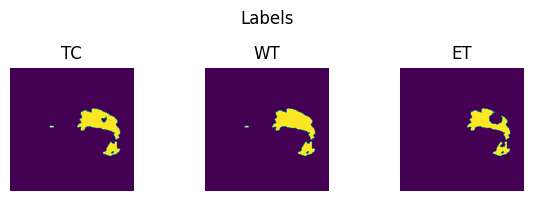

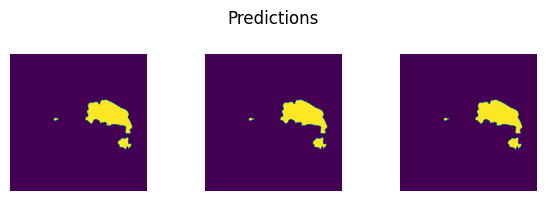

VAL
   Batch 1/31, val_loss: 0.8269
   Batch 2/31, val_loss: 0.9844
   Batch 3/31, val_loss: 0.9799
   Batch 4/31, val_loss: 0.9729
   Batch 5/31, val_loss: 0.9970
   Batch 6/31, val_loss: 0.1450
   Batch 7/31, val_loss: 0.7718
   Batch 8/31, val_loss: 0.9670
   Batch 9/31, val_loss: 0.1715
   Batch 10/31, val_loss: 0.9244
   Batch 11/31, val_loss: 0.8164
   Batch 12/31, val_loss: 0.9354
   Batch 13/31, val_loss: 0.9474
   Batch 14/31, val_loss: 0.8566
   Batch 15/31, val_loss: 0.9794
   Batch 16/31, val_loss: 0.9831
   Batch 17/31, val_loss: 0.9859
   Batch 18/31, val_loss: 0.9488
   Batch 19/31, val_loss: 0.3672
   Batch 20/31, val_loss: 0.8595
   Batch 21/31, val_loss: 0.9080
   Batch 22/31, val_loss: 0.9975
   Batch 23/31, val_loss: 0.8921
   Batch 24/31, val_loss: 0.0587
   Batch 25/31, val_loss: 0.6565
   Batch 26/31, val_loss: 0.9329
   Batch 27/31, val_loss: 0.9914
   Batch 28/31, val_loss: 0.5730
   Batch 29/31, val_loss: 0.9930
   Batch 30/31, val_loss: 0.9674
   Batch 31/31,

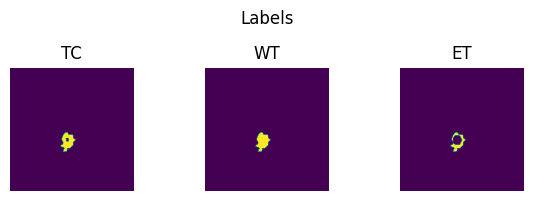

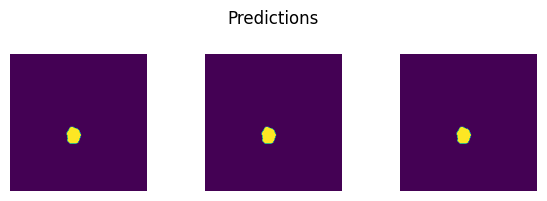

epoch 85
   average train loss: 0.4863
   average validation loss: 0.8184
   saved as best model: True
   current mean dice: 0.3730
   current TC dice: 0.3931
   current WT dice: 0.4009
   current ET dice: 0.3597
Best Mean Metric: 0.3730
time consuming of epoch 85 is: 1426.9282
----------
epoch 86/100
TRAIN
   Batch 1/248, train_loss: 0.1241, step time: 0.3840
   Batch 2/248, train_loss: 0.9995, step time: 0.3622
   Batch 3/248, train_loss: 0.7341, step time: 0.3704
   Batch 4/248, train_loss: 0.9991, step time: 0.3427
   Batch 5/248, train_loss: 0.4410, step time: 0.3850
   Batch 6/248, train_loss: 0.6184, step time: 0.3753
   Batch 7/248, train_loss: 0.1072, step time: 0.3866
   Batch 8/248, train_loss: 0.7612, step time: 0.3869
   Batch 9/248, train_loss: 0.0665, step time: 0.3564
   Batch 10/248, train_loss: 0.5250, step time: 0.3538
   Batch 11/248, train_loss: 0.3598, step time: 0.3544
   Batch 12/248, train_loss: 0.9719, step time: 0.3716
   Batch 13/248, train_loss: 0.8320, ste

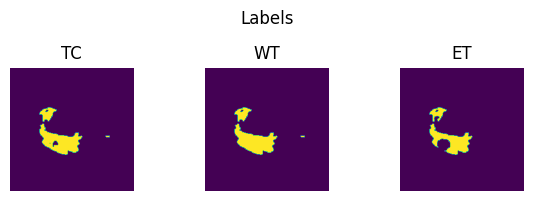

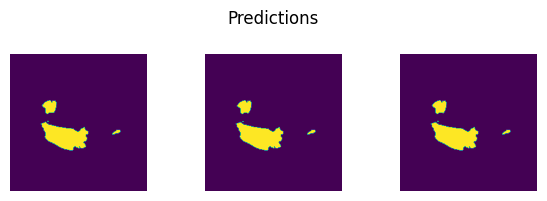

VAL
   Batch 1/31, val_loss: 0.7662
   Batch 2/31, val_loss: 0.9326
   Batch 3/31, val_loss: 0.9403
   Batch 4/31, val_loss: 0.9398
   Batch 5/31, val_loss: 0.9908
   Batch 6/31, val_loss: 0.1246
   Batch 7/31, val_loss: 0.6907
   Batch 8/31, val_loss: 0.9494
   Batch 9/31, val_loss: 0.1593
   Batch 10/31, val_loss: 0.8429
   Batch 11/31, val_loss: 0.7746
   Batch 12/31, val_loss: 0.8396
   Batch 13/31, val_loss: 0.9427
   Batch 14/31, val_loss: 0.7140
   Batch 15/31, val_loss: 0.9999
   Batch 16/31, val_loss: 0.9707
   Batch 17/31, val_loss: 0.9782
   Batch 18/31, val_loss: 0.9169
   Batch 19/31, val_loss: 0.2670
   Batch 20/31, val_loss: 0.8399
   Batch 21/31, val_loss: 0.8661
   Batch 22/31, val_loss: 0.9885
   Batch 23/31, val_loss: 0.7898
   Batch 24/31, val_loss: 0.0584
   Batch 25/31, val_loss: 0.5730
   Batch 26/31, val_loss: 0.9251
   Batch 27/31, val_loss: 0.9467
   Batch 28/31, val_loss: 0.4576
   Batch 29/31, val_loss: 0.9862
   Batch 30/31, val_loss: 0.9195
   Batch 31/31,

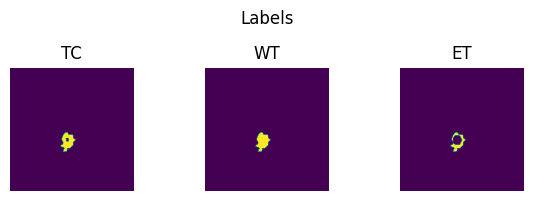

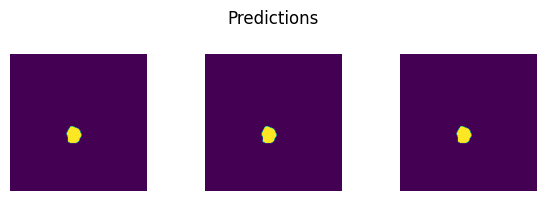

epoch 86
   average train loss: 0.4765
   average validation loss: 0.7763
   saved as best model: True
   current mean dice: 0.3767
   current TC dice: 0.3977
   current WT dice: 0.4053
   current ET dice: 0.3618
Best Mean Metric: 0.3767
time consuming of epoch 86 is: 1423.3315
----------
epoch 87/100
TRAIN
   Batch 1/248, train_loss: 0.1125, step time: 0.3866
   Batch 2/248, train_loss: 1.0000, step time: 0.3474
   Batch 3/248, train_loss: 0.7168, step time: 0.3810
   Batch 4/248, train_loss: 1.0000, step time: 0.3543
   Batch 5/248, train_loss: 0.3145, step time: 0.3850
   Batch 6/248, train_loss: 0.6254, step time: 0.3567
   Batch 7/248, train_loss: 0.1069, step time: 0.3800
   Batch 8/248, train_loss: 0.7483, step time: 0.3636
   Batch 9/248, train_loss: 0.0698, step time: 0.3504
   Batch 10/248, train_loss: 0.4923, step time: 0.3560
   Batch 11/248, train_loss: 0.3382, step time: 0.3809
   Batch 12/248, train_loss: 0.9575, step time: 0.3633
   Batch 13/248, train_loss: 0.7882, ste

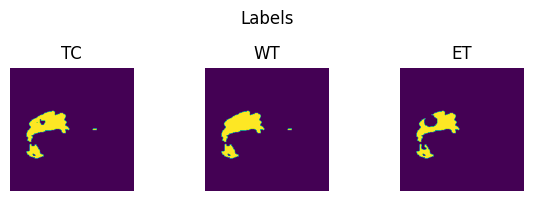

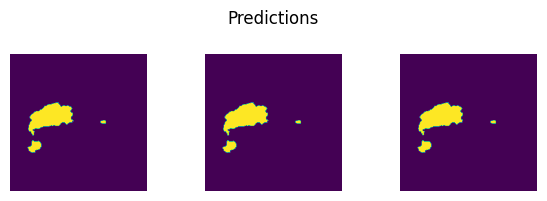

VAL
   Batch 1/31, val_loss: 0.7977
   Batch 2/31, val_loss: 0.9424
   Batch 3/31, val_loss: 0.8642
   Batch 4/31, val_loss: 0.9153
   Batch 5/31, val_loss: 0.9857
   Batch 6/31, val_loss: 0.1356
   Batch 7/31, val_loss: 0.7132
   Batch 8/31, val_loss: 0.9350
   Batch 9/31, val_loss: 0.1582
   Batch 10/31, val_loss: 0.8615
   Batch 11/31, val_loss: 0.7880
   Batch 12/31, val_loss: 0.8947
   Batch 13/31, val_loss: 0.9195
   Batch 14/31, val_loss: 0.7096
   Batch 15/31, val_loss: 0.8932
   Batch 16/31, val_loss: 0.9709
   Batch 17/31, val_loss: 0.9699
   Batch 18/31, val_loss: 0.9075
   Batch 19/31, val_loss: 0.2682
   Batch 20/31, val_loss: 0.8558
   Batch 21/31, val_loss: 0.8914
   Batch 22/31, val_loss: 0.9852
   Batch 23/31, val_loss: 0.8061
   Batch 24/31, val_loss: 0.0594
   Batch 25/31, val_loss: 0.5699
   Batch 26/31, val_loss: 0.9235
   Batch 27/31, val_loss: 0.9369
   Batch 28/31, val_loss: 0.4534
   Batch 29/31, val_loss: 0.9873
   Batch 30/31, val_loss: 0.8645
   Batch 31/31,

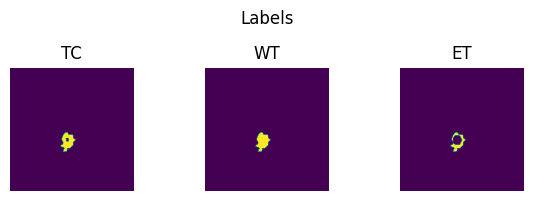

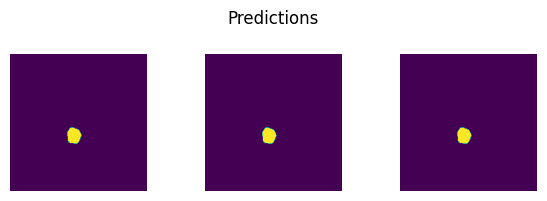

epoch 87
   average train loss: 0.4852
   average validation loss: 0.7721
   saved as best model: False
   current mean dice: 0.3763
   current TC dice: 0.3981
   current WT dice: 0.4059
   current ET dice: 0.3593
Best Mean Metric: 0.3767
time consuming of epoch 87 is: 1410.7615
----------
epoch 88/100
TRAIN
   Batch 1/248, train_loss: 0.1223, step time: 0.3649
   Batch 2/248, train_loss: 0.9999, step time: 0.3457
   Batch 3/248, train_loss: 0.6996, step time: 0.3658
   Batch 4/248, train_loss: 1.0000, step time: 0.3442
   Batch 5/248, train_loss: 0.4543, step time: 0.3454
   Batch 6/248, train_loss: 0.6327, step time: 0.3650
   Batch 7/248, train_loss: 0.1076, step time: 0.3442
   Batch 8/248, train_loss: 0.7356, step time: 0.3537
   Batch 9/248, train_loss: 0.0695, step time: 0.3652
   Batch 10/248, train_loss: 0.4809, step time: 0.3702
   Batch 11/248, train_loss: 0.3717, step time: 0.3575
   Batch 12/248, train_loss: 0.9874, step time: 0.3818
   Batch 13/248, train_loss: 0.8095, st

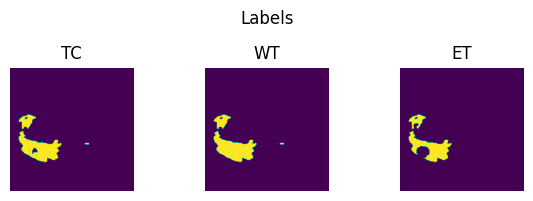

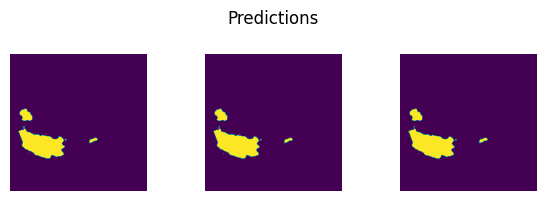

VAL
   Batch 1/31, val_loss: 0.7601
   Batch 2/31, val_loss: 0.9071
   Batch 3/31, val_loss: 0.7793
   Batch 4/31, val_loss: 0.8483
   Batch 5/31, val_loss: 0.9763
   Batch 6/31, val_loss: 0.1392
   Batch 7/31, val_loss: 0.6542
   Batch 8/31, val_loss: 0.8936
   Batch 9/31, val_loss: 0.1374
   Batch 10/31, val_loss: 0.7532
   Batch 11/31, val_loss: 0.7563
   Batch 12/31, val_loss: 0.8350
   Batch 13/31, val_loss: 0.9317
   Batch 14/31, val_loss: 0.6203
   Batch 15/31, val_loss: 0.8701
   Batch 16/31, val_loss: 0.9557
   Batch 17/31, val_loss: 0.9323
   Batch 18/31, val_loss: 0.8456
   Batch 19/31, val_loss: 0.2329
   Batch 20/31, val_loss: 0.8184
   Batch 21/31, val_loss: 0.8662
   Batch 22/31, val_loss: 0.9763
   Batch 23/31, val_loss: 0.8114
   Batch 24/31, val_loss: 0.0617
   Batch 25/31, val_loss: 0.4924
   Batch 26/31, val_loss: 0.9155
   Batch 27/31, val_loss: 0.8491
   Batch 28/31, val_loss: 0.4060
   Batch 29/31, val_loss: 0.9748
   Batch 30/31, val_loss: 0.7910
   Batch 31/31,

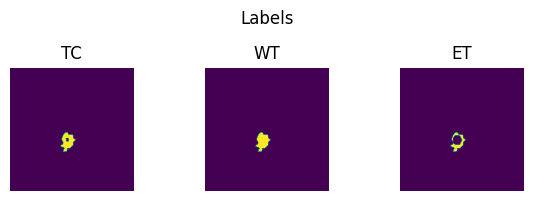

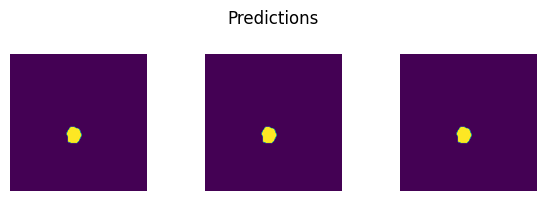

epoch 88
   average train loss: 0.4820
   average validation loss: 0.7339
   saved as best model: True
   current mean dice: 0.3876
   current TC dice: 0.4101
   current WT dice: 0.4180
   current ET dice: 0.3697
Best Mean Metric: 0.3876
time consuming of epoch 88 is: 1402.6976
----------
epoch 89/100
TRAIN
   Batch 1/248, train_loss: 0.1168, step time: 0.3881
   Batch 2/248, train_loss: 0.9881, step time: 0.3465
   Batch 3/248, train_loss: 0.6917, step time: 0.3450
   Batch 4/248, train_loss: 1.0000, step time: 0.3433
   Batch 5/248, train_loss: 0.4698, step time: 0.3812
   Batch 6/248, train_loss: 0.4815, step time: 0.3605
   Batch 7/248, train_loss: 0.1068, step time: 0.3826
   Batch 8/248, train_loss: 0.7357, step time: 0.3537
   Batch 9/248, train_loss: 0.0684, step time: 0.3450
   Batch 10/248, train_loss: 0.4706, step time: 0.3453
   Batch 11/248, train_loss: 0.3180, step time: 0.3880
   Batch 12/248, train_loss: 0.9538, step time: 0.3637
   Batch 13/248, train_loss: 0.7666, ste

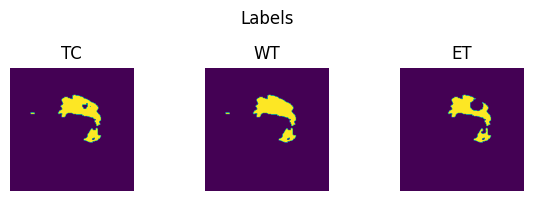

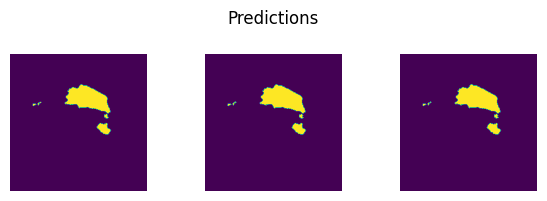

VAL
   Batch 1/31, val_loss: 0.7211
   Batch 2/31, val_loss: 0.8571
   Batch 3/31, val_loss: 0.6990
   Batch 4/31, val_loss: 0.7174
   Batch 5/31, val_loss: 0.9644
   Batch 6/31, val_loss: 0.1277
   Batch 7/31, val_loss: 0.6189
   Batch 8/31, val_loss: 0.8159
   Batch 9/31, val_loss: 0.1376
   Batch 10/31, val_loss: 0.6485
   Batch 11/31, val_loss: 0.6858
   Batch 12/31, val_loss: 0.7374
   Batch 13/31, val_loss: 0.8665
   Batch 14/31, val_loss: 0.5889
   Batch 15/31, val_loss: 0.6445
   Batch 16/31, val_loss: 0.9220
   Batch 17/31, val_loss: 0.9195
   Batch 18/31, val_loss: 0.7499
   Batch 19/31, val_loss: 0.2039
   Batch 20/31, val_loss: 0.7835
   Batch 21/31, val_loss: 0.8204
   Batch 22/31, val_loss: 0.9658
   Batch 23/31, val_loss: 0.6667
   Batch 24/31, val_loss: 0.0494
   Batch 25/31, val_loss: 0.4610
   Batch 26/31, val_loss: 0.8922
   Batch 27/31, val_loss: 0.7202
   Batch 28/31, val_loss: 0.3972
   Batch 29/31, val_loss: 0.9635
   Batch 30/31, val_loss: 0.6297
   Batch 31/31,

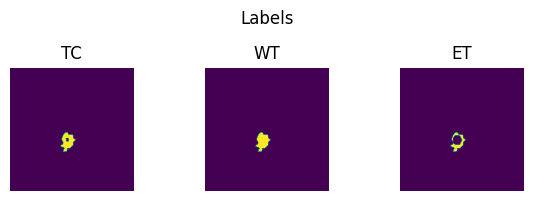

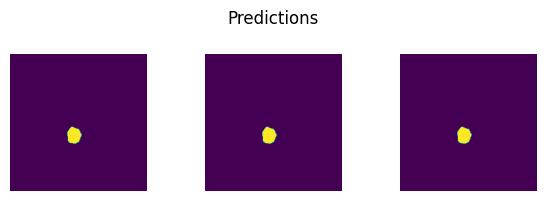

epoch 89
   average train loss: 0.4669
   average validation loss: 0.6751
   saved as best model: False
   current mean dice: 0.3832
   current TC dice: 0.4046
   current WT dice: 0.4129
   current ET dice: 0.3674
Best Mean Metric: 0.3876
time consuming of epoch 89 is: 1408.7282
----------
epoch 90/100
TRAIN
   Batch 1/248, train_loss: 0.1169, step time: 0.3871
   Batch 2/248, train_loss: 0.9842, step time: 0.3413
   Batch 3/248, train_loss: 0.6831, step time: 0.3538
   Batch 4/248, train_loss: 0.9982, step time: 0.3428
   Batch 5/248, train_loss: 0.3674, step time: 0.3781
   Batch 6/248, train_loss: 0.6087, step time: 0.3790
   Batch 7/248, train_loss: 0.0976, step time: 0.3715
   Batch 8/248, train_loss: 0.7150, step time: 0.3565
   Batch 9/248, train_loss: 0.0651, step time: 0.3432
   Batch 10/248, train_loss: 0.4929, step time: 0.3449
   Batch 11/248, train_loss: 0.3085, step time: 0.3423
   Batch 12/248, train_loss: 0.9633, step time: 0.3633
   Batch 13/248, train_loss: 0.7907, st

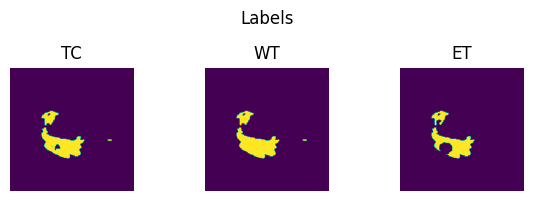

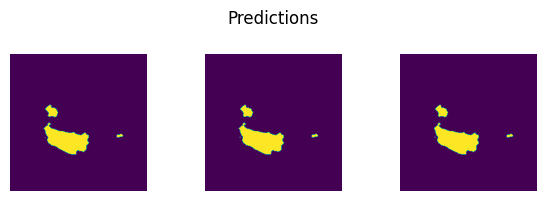

VAL
   Batch 1/31, val_loss: 0.7540
   Batch 2/31, val_loss: 0.8427
   Batch 3/31, val_loss: 0.6883
   Batch 4/31, val_loss: 0.6899
   Batch 5/31, val_loss: 0.9566
   Batch 6/31, val_loss: 0.1364
   Batch 7/31, val_loss: 0.6224
   Batch 8/31, val_loss: 0.7934
   Batch 9/31, val_loss: 0.1809
   Batch 10/31, val_loss: 0.6251
   Batch 11/31, val_loss: 0.6996
   Batch 12/31, val_loss: 0.8272
   Batch 13/31, val_loss: 0.9164
   Batch 14/31, val_loss: 0.6045
   Batch 15/31, val_loss: 0.7805
   Batch 16/31, val_loss: 0.9122
   Batch 17/31, val_loss: 0.8830
   Batch 18/31, val_loss: 0.7860
   Batch 19/31, val_loss: 0.2173
   Batch 20/31, val_loss: 0.8183
   Batch 21/31, val_loss: 0.8257
   Batch 22/31, val_loss: 0.9512
   Batch 23/31, val_loss: 0.7157
   Batch 24/31, val_loss: 0.0602
   Batch 25/31, val_loss: 0.4305
   Batch 26/31, val_loss: 0.8897
   Batch 27/31, val_loss: 0.6775
   Batch 28/31, val_loss: 0.4040
   Batch 29/31, val_loss: 0.9393
   Batch 30/31, val_loss: 0.7685
   Batch 31/31,

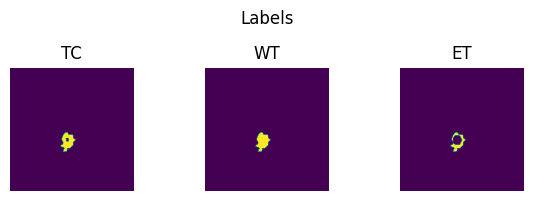

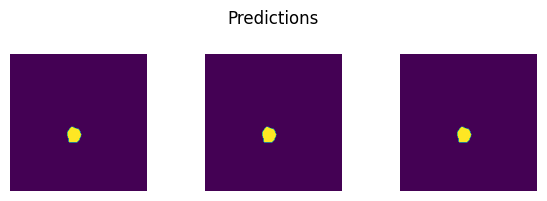

epoch 90
   average train loss: 0.4655
   average validation loss: 0.6881
   saved as best model: True
   current mean dice: 0.3952
   current TC dice: 0.4171
   current WT dice: 0.4257
   current ET dice: 0.3793
Best Mean Metric: 0.3952
time consuming of epoch 90 is: 1407.0698
----------
epoch 91/100
TRAIN
   Batch 1/248, train_loss: 0.1646, step time: 0.3832
   Batch 2/248, train_loss: 0.9999, step time: 0.3517
   Batch 3/248, train_loss: 0.6559, step time: 0.3740
   Batch 4/248, train_loss: 0.9993, step time: 0.3646
   Batch 5/248, train_loss: 0.4355, step time: 0.3821
   Batch 6/248, train_loss: 0.5617, step time: 0.3740
   Batch 7/248, train_loss: 0.1094, step time: 0.3814
   Batch 8/248, train_loss: 0.7493, step time: 0.3671
   Batch 9/248, train_loss: 0.0680, step time: 0.3600
   Batch 10/248, train_loss: 0.4214, step time: 0.3676
   Batch 11/248, train_loss: 0.3343, step time: 0.3761
   Batch 12/248, train_loss: 0.9258, step time: 0.3523
   Batch 13/248, train_loss: 0.7797, ste

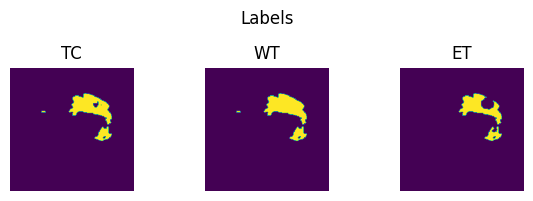

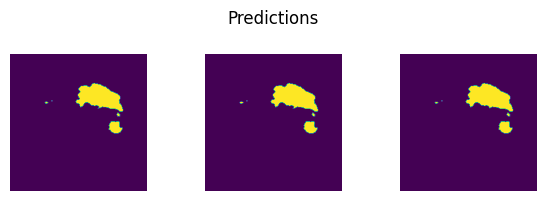

VAL
   Batch 1/31, val_loss: 0.6941
   Batch 2/31, val_loss: 0.8376
   Batch 3/31, val_loss: 0.6619
   Batch 4/31, val_loss: 0.6378
   Batch 5/31, val_loss: 0.9564
   Batch 6/31, val_loss: 0.1045
   Batch 7/31, val_loss: 0.5191
   Batch 8/31, val_loss: 0.7557
   Batch 9/31, val_loss: 0.1299
   Batch 10/31, val_loss: 0.5841
   Batch 11/31, val_loss: 0.6431
   Batch 12/31, val_loss: 0.7870
   Batch 13/31, val_loss: 0.8164
   Batch 14/31, val_loss: 0.5756
   Batch 15/31, val_loss: 0.8641
   Batch 16/31, val_loss: 0.8961
   Batch 17/31, val_loss: 0.8790
   Batch 18/31, val_loss: 0.7085
   Batch 19/31, val_loss: 0.1891
   Batch 20/31, val_loss: 0.7174
   Batch 21/31, val_loss: 0.7680
   Batch 22/31, val_loss: 0.9467
   Batch 23/31, val_loss: 0.6624
   Batch 24/31, val_loss: 0.0479
   Batch 25/31, val_loss: 0.3842
   Batch 26/31, val_loss: 0.8718
   Batch 27/31, val_loss: 0.6507
   Batch 28/31, val_loss: 0.3723
   Batch 29/31, val_loss: 0.9206
   Batch 30/31, val_loss: 0.6055
   Batch 31/31,

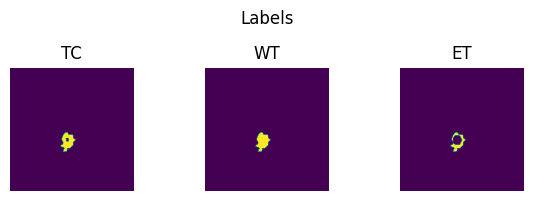

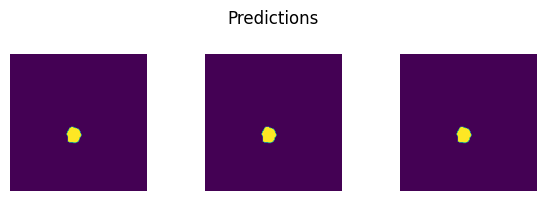

epoch 91
   average train loss: 0.4557
   average validation loss: 0.6490
   saved as best model: True
   current mean dice: 0.4030
   current TC dice: 0.4251
   current WT dice: 0.4330
   current ET dice: 0.3878
Best Mean Metric: 0.4030
time consuming of epoch 91 is: 1406.2728
----------
epoch 92/100
TRAIN
   Batch 1/248, train_loss: 0.1023, step time: 0.3448
   Batch 2/248, train_loss: 1.0000, step time: 0.3678
   Batch 3/248, train_loss: 0.6859, step time: 0.3594
   Batch 4/248, train_loss: 0.9999, step time: 0.3805
   Batch 5/248, train_loss: 0.4107, step time: 0.3553
   Batch 6/248, train_loss: 0.6040, step time: 0.3491
   Batch 7/248, train_loss: 0.1071, step time: 0.3472
   Batch 8/248, train_loss: 0.7127, step time: 0.3812
   Batch 9/248, train_loss: 0.0623, step time: 0.3445
   Batch 10/248, train_loss: 0.4563, step time: 0.3620
   Batch 11/248, train_loss: 0.3362, step time: 0.3836
   Batch 12/248, train_loss: 0.9297, step time: 0.3586
   Batch 13/248, train_loss: 0.8216, ste

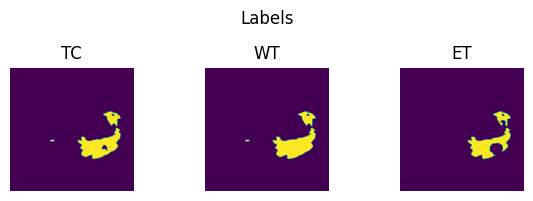

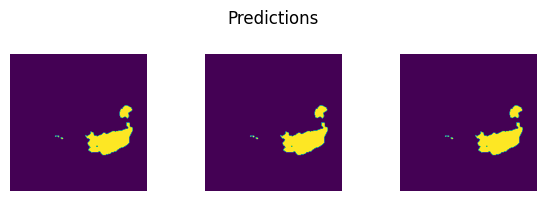

VAL
   Batch 1/31, val_loss: 0.6860
   Batch 2/31, val_loss: 0.7645
   Batch 3/31, val_loss: 0.6546
   Batch 4/31, val_loss: 0.6215
   Batch 5/31, val_loss: 0.8892
   Batch 6/31, val_loss: 0.1258
   Batch 7/31, val_loss: 0.5311
   Batch 8/31, val_loss: 0.6135
   Batch 9/31, val_loss: 0.1686
   Batch 10/31, val_loss: 0.5748
   Batch 11/31, val_loss: 0.6548
   Batch 12/31, val_loss: 0.6899
   Batch 13/31, val_loss: 0.8079
   Batch 14/31, val_loss: 0.5812
   Batch 15/31, val_loss: 0.7309
   Batch 16/31, val_loss: 0.8621
   Batch 17/31, val_loss: 0.7628
   Batch 18/31, val_loss: 0.6055
   Batch 19/31, val_loss: 0.1946
   Batch 20/31, val_loss: 0.7280
   Batch 21/31, val_loss: 0.7409
   Batch 22/31, val_loss: 0.8924
   Batch 23/31, val_loss: 0.5885
   Batch 24/31, val_loss: 0.0533
   Batch 25/31, val_loss: 0.4216
   Batch 26/31, val_loss: 0.8708
   Batch 27/31, val_loss: 0.6311
   Batch 28/31, val_loss: 0.3916
   Batch 29/31, val_loss: 0.8657
   Batch 30/31, val_loss: 0.6005
   Batch 31/31,

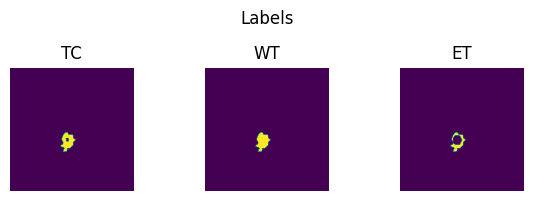

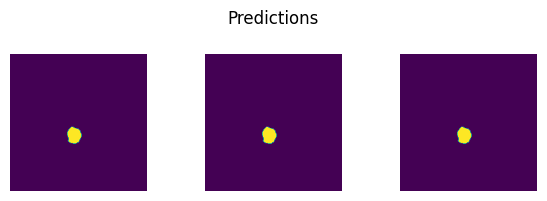

epoch 92
   average train loss: 0.4633
   average validation loss: 0.6186
   saved as best model: True
   current mean dice: 0.4090
   current TC dice: 0.4320
   current WT dice: 0.4401
   current ET dice: 0.3928
Best Mean Metric: 0.4090
time consuming of epoch 92 is: 1406.6796
----------
epoch 93/100
TRAIN
   Batch 1/248, train_loss: 0.1161, step time: 0.3733
   Batch 2/248, train_loss: 0.9999, step time: 0.3877
   Batch 3/248, train_loss: 0.6767, step time: 0.3634
   Batch 4/248, train_loss: 1.0000, step time: 0.3568
   Batch 5/248, train_loss: 0.3299, step time: 0.3467
   Batch 6/248, train_loss: 0.6450, step time: 0.3659
   Batch 7/248, train_loss: 0.1065, step time: 0.3658
   Batch 8/248, train_loss: 0.7606, step time: 0.3488
   Batch 9/248, train_loss: 0.0637, step time: 0.3635
   Batch 10/248, train_loss: 0.4389, step time: 0.3662
   Batch 11/248, train_loss: 0.3425, step time: 0.3824
   Batch 12/248, train_loss: 0.9236, step time: 0.3684
   Batch 13/248, train_loss: 0.6996, ste

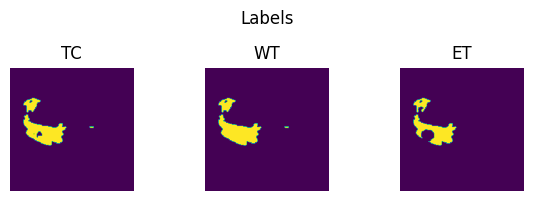

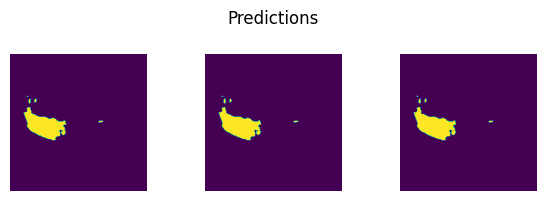

VAL
   Batch 1/31, val_loss: 0.5875
   Batch 2/31, val_loss: 0.7203
   Batch 3/31, val_loss: 0.6343
   Batch 4/31, val_loss: 0.6081
   Batch 5/31, val_loss: 0.8560
   Batch 6/31, val_loss: 0.1405
   Batch 7/31, val_loss: 0.4912
   Batch 8/31, val_loss: 0.5792
   Batch 9/31, val_loss: 0.1341
   Batch 10/31, val_loss: 0.5630
   Batch 11/31, val_loss: 0.5733
   Batch 12/31, val_loss: 0.6961
   Batch 13/31, val_loss: 0.7461
   Batch 14/31, val_loss: 0.5762
   Batch 15/31, val_loss: 0.6318
   Batch 16/31, val_loss: 0.8158
   Batch 17/31, val_loss: 0.6530
   Batch 18/31, val_loss: 0.5972
   Batch 19/31, val_loss: 0.1946
   Batch 20/31, val_loss: 0.6508
   Batch 21/31, val_loss: 0.6770
   Batch 22/31, val_loss: 0.8419
   Batch 23/31, val_loss: 0.4979
   Batch 24/31, val_loss: 0.0474
   Batch 25/31, val_loss: 0.3747
   Batch 26/31, val_loss: 0.8112
   Batch 27/31, val_loss: 0.5944
   Batch 28/31, val_loss: 0.3552
   Batch 29/31, val_loss: 0.7054
   Batch 30/31, val_loss: 0.5850
   Batch 31/31,

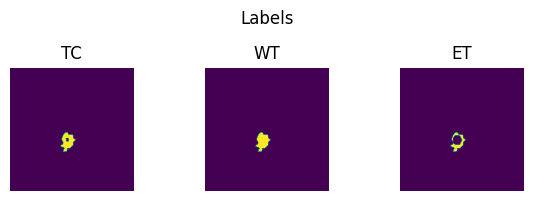

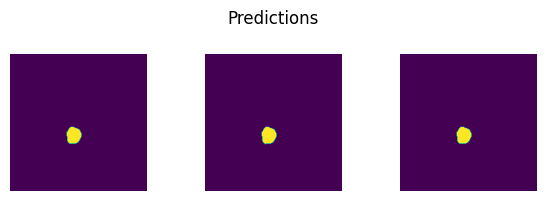

epoch 93
   average train loss: 0.4547
   average validation loss: 0.5729
   saved as best model: False
   current mean dice: 0.4005
   current TC dice: 0.4219
   current WT dice: 0.4298
   current ET dice: 0.3873
Best Mean Metric: 0.4090
time consuming of epoch 93 is: 1402.9663
----------
epoch 94/100
TRAIN
   Batch 1/248, train_loss: 0.1396, step time: 0.3524
   Batch 2/248, train_loss: 0.9833, step time: 0.3730
   Batch 3/248, train_loss: 0.7026, step time: 0.3892
   Batch 4/248, train_loss: 1.0000, step time: 0.3468
   Batch 5/248, train_loss: 0.3899, step time: 0.3875
   Batch 6/248, train_loss: 0.6106, step time: 0.3772
   Batch 7/248, train_loss: 0.0998, step time: 0.3431
   Batch 8/248, train_loss: 0.7448, step time: 0.3711
   Batch 9/248, train_loss: 0.0659, step time: 0.3889
   Batch 10/248, train_loss: 0.3901, step time: 0.3709
   Batch 11/248, train_loss: 0.3488, step time: 0.3693
   Batch 12/248, train_loss: 0.9367, step time: 0.3604
   Batch 13/248, train_loss: 0.6952, st

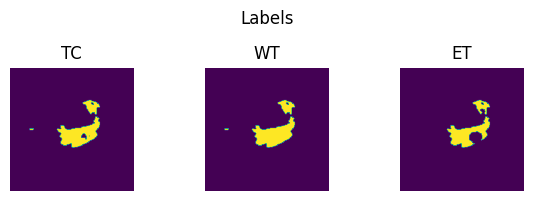

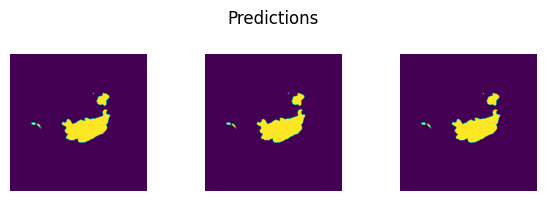

VAL
   Batch 1/31, val_loss: 0.5465
   Batch 2/31, val_loss: 0.6723
   Batch 3/31, val_loss: 0.6251
   Batch 4/31, val_loss: 0.5913
   Batch 5/31, val_loss: 0.7709
   Batch 6/31, val_loss: 0.0974
   Batch 7/31, val_loss: 0.3428
   Batch 8/31, val_loss: 0.4638
   Batch 9/31, val_loss: 0.1408
   Batch 10/31, val_loss: 0.5432
   Batch 11/31, val_loss: 0.5141
   Batch 12/31, val_loss: 0.6217
   Batch 13/31, val_loss: 0.5688
   Batch 14/31, val_loss: 0.5467
   Batch 15/31, val_loss: 0.6357
   Batch 16/31, val_loss: 0.7569
   Batch 17/31, val_loss: 0.6173
   Batch 18/31, val_loss: 0.4954
   Batch 19/31, val_loss: 0.1795
   Batch 20/31, val_loss: 0.6389
   Batch 21/31, val_loss: 0.6124
   Batch 22/31, val_loss: 0.7229
   Batch 23/31, val_loss: 0.4483
   Batch 24/31, val_loss: 0.0512
   Batch 25/31, val_loss: 0.3142
   Batch 26/31, val_loss: 0.7776
   Batch 27/31, val_loss: 0.6051
   Batch 28/31, val_loss: 0.3621
   Batch 29/31, val_loss: 0.7519
   Batch 30/31, val_loss: 0.5745
   Batch 31/31,

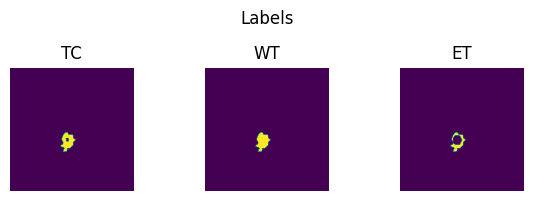

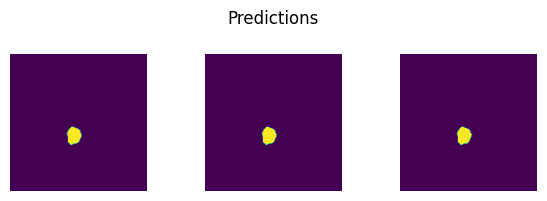

epoch 94
   average train loss: 0.4502
   average validation loss: 0.5249
   saved as best model: False
   current mean dice: 0.4003
   current TC dice: 0.4215
   current WT dice: 0.4287
   current ET dice: 0.3881
Best Mean Metric: 0.4090
time consuming of epoch 94 is: 1403.1740
----------
epoch 95/100
TRAIN
   Batch 1/248, train_loss: 0.1073, step time: 0.3599
   Batch 2/248, train_loss: 1.0000, step time: 0.3896
   Batch 3/248, train_loss: 0.6252, step time: 0.3460
   Batch 4/248, train_loss: 0.9979, step time: 0.3881
   Batch 5/248, train_loss: 0.3547, step time: 0.3529
   Batch 6/248, train_loss: 0.6012, step time: 0.3481
   Batch 7/248, train_loss: 0.1107, step time: 0.3439
   Batch 8/248, train_loss: 0.7460, step time: 0.3424
   Batch 9/248, train_loss: 0.0689, step time: 0.3441
   Batch 10/248, train_loss: 0.4041, step time: 0.3656
   Batch 11/248, train_loss: 0.3222, step time: 0.3827
   Batch 12/248, train_loss: 0.8670, step time: 0.3837
   Batch 13/248, train_loss: 0.7306, st

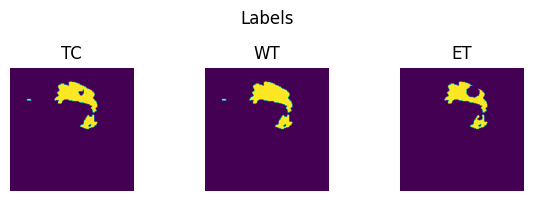

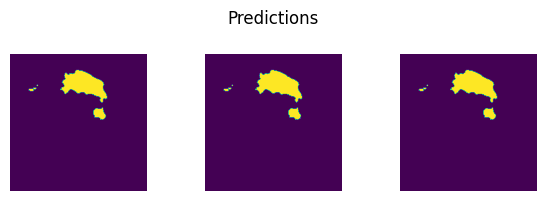

VAL
   Batch 1/31, val_loss: 0.6014
   Batch 2/31, val_loss: 0.6850
   Batch 3/31, val_loss: 0.6160
   Batch 4/31, val_loss: 0.5880
   Batch 5/31, val_loss: 0.7355
   Batch 6/31, val_loss: 0.1128
   Batch 7/31, val_loss: 0.4905
   Batch 8/31, val_loss: 0.4431
   Batch 9/31, val_loss: 0.1753
   Batch 10/31, val_loss: 0.5458
   Batch 11/31, val_loss: 0.5670
   Batch 12/31, val_loss: 0.6021
   Batch 13/31, val_loss: 0.5602
   Batch 14/31, val_loss: 0.5643
   Batch 15/31, val_loss: 0.6090
   Batch 16/31, val_loss: 0.7065
   Batch 17/31, val_loss: 0.5081
   Batch 18/31, val_loss: 0.4827
   Batch 19/31, val_loss: 0.1801
   Batch 20/31, val_loss: 0.6586
   Batch 21/31, val_loss: 0.6696
   Batch 22/31, val_loss: 0.7187
   Batch 23/31, val_loss: 0.5208
   Batch 24/31, val_loss: 0.0501
   Batch 25/31, val_loss: 0.3579
   Batch 26/31, val_loss: 0.8104
   Batch 27/31, val_loss: 0.5743
   Batch 28/31, val_loss: 0.3862
   Batch 29/31, val_loss: 0.6912
   Batch 30/31, val_loss: 0.5438
   Batch 31/31,

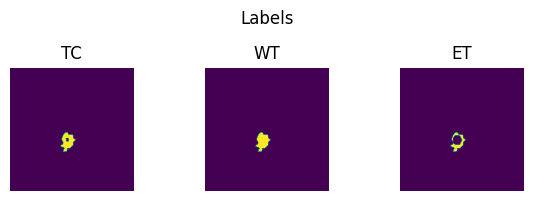

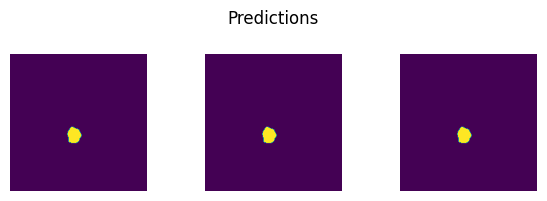

epoch 95
   average train loss: 0.4475
   average validation loss: 0.5300
   saved as best model: True
   current mean dice: 0.4234
   current TC dice: 0.4489
   current WT dice: 0.4574
   current ET dice: 0.4025
Best Mean Metric: 0.4234
time consuming of epoch 95 is: 1398.8912
----------
epoch 96/100
TRAIN
   Batch 1/248, train_loss: 0.1075, step time: 0.3656
   Batch 2/248, train_loss: 0.9957, step time: 0.3839
   Batch 3/248, train_loss: 0.5554, step time: 0.3835
   Batch 4/248, train_loss: 1.0000, step time: 0.3539
   Batch 5/248, train_loss: 0.3400, step time: 0.3429
   Batch 6/248, train_loss: 0.4440, step time: 0.3681
   Batch 7/248, train_loss: 0.1094, step time: 0.3664
   Batch 8/248, train_loss: 0.7193, step time: 0.3464
   Batch 9/248, train_loss: 0.0650, step time: 0.3655
   Batch 10/248, train_loss: 0.4503, step time: 0.3775
   Batch 11/248, train_loss: 0.3276, step time: 0.3445
   Batch 12/248, train_loss: 0.8298, step time: 0.3899
   Batch 13/248, train_loss: 0.6311, ste

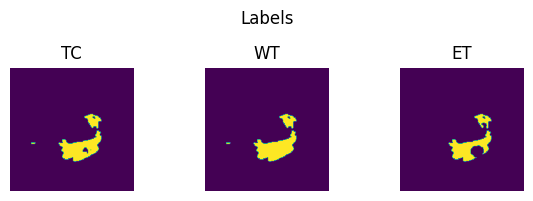

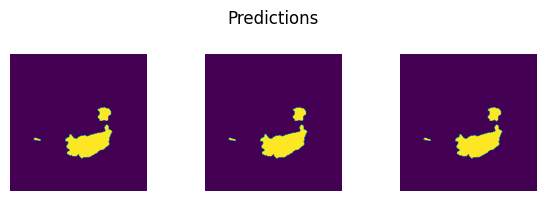

VAL
   Batch 1/31, val_loss: 0.5033
   Batch 2/31, val_loss: 0.6268
   Batch 3/31, val_loss: 0.6156
   Batch 4/31, val_loss: 0.5842
   Batch 5/31, val_loss: 0.6555
   Batch 6/31, val_loss: 0.1019
   Batch 7/31, val_loss: 0.4250
   Batch 8/31, val_loss: 0.4433
   Batch 9/31, val_loss: 0.1907
   Batch 10/31, val_loss: 0.5332
   Batch 11/31, val_loss: 0.4433
   Batch 12/31, val_loss: 0.5883
   Batch 13/31, val_loss: 0.5497
   Batch 14/31, val_loss: 0.5645
   Batch 15/31, val_loss: 0.5662
   Batch 16/31, val_loss: 0.5809
   Batch 17/31, val_loss: 0.5035
   Batch 18/31, val_loss: 0.4618
   Batch 19/31, val_loss: 0.1853
   Batch 20/31, val_loss: 0.5574
   Batch 21/31, val_loss: 0.5797
   Batch 22/31, val_loss: 0.5719
   Batch 23/31, val_loss: 0.4849
   Batch 24/31, val_loss: 0.0540
   Batch 25/31, val_loss: 0.3061
   Batch 26/31, val_loss: 0.6705
   Batch 27/31, val_loss: 0.5763
   Batch 28/31, val_loss: 0.3692
   Batch 29/31, val_loss: 0.6197
   Batch 30/31, val_loss: 0.5412
   Batch 31/31,

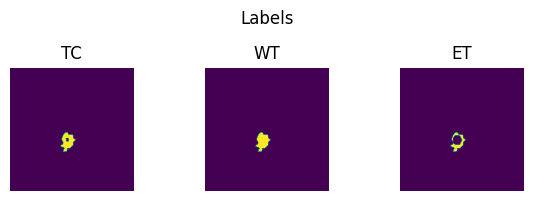

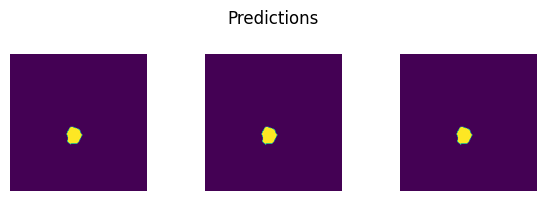

epoch 96
   average train loss: 0.4445
   average validation loss: 0.4851
   saved as best model: False
   current mean dice: 0.4208
   current TC dice: 0.4434
   current WT dice: 0.4515
   current ET dice: 0.4070
Best Mean Metric: 0.4234
time consuming of epoch 96 is: 1401.6798
----------
epoch 97/100
TRAIN
   Batch 1/248, train_loss: 0.1077, step time: 0.3890
   Batch 2/248, train_loss: 0.9910, step time: 0.3524
   Batch 3/248, train_loss: 0.6888, step time: 0.3835
   Batch 4/248, train_loss: 0.9996, step time: 0.3819
   Batch 5/248, train_loss: 0.3594, step time: 0.3585
   Batch 6/248, train_loss: 0.4741, step time: 0.3888
   Batch 7/248, train_loss: 0.1088, step time: 0.3872
   Batch 8/248, train_loss: 0.7535, step time: 0.3537
   Batch 9/248, train_loss: 0.0741, step time: 0.3436
   Batch 10/248, train_loss: 0.4152, step time: 0.3464
   Batch 11/248, train_loss: 0.3062, step time: 0.3454
   Batch 12/248, train_loss: 0.7980, step time: 0.3472
   Batch 13/248, train_loss: 0.6791, st

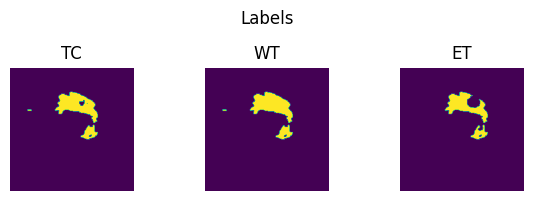

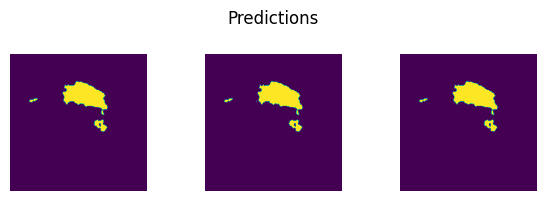

VAL
   Batch 1/31, val_loss: 0.4820
   Batch 2/31, val_loss: 0.6048
   Batch 3/31, val_loss: 0.5466
   Batch 4/31, val_loss: 0.5727
   Batch 5/31, val_loss: 0.6322
   Batch 6/31, val_loss: 0.1132
   Batch 7/31, val_loss: 0.3593
   Batch 8/31, val_loss: 0.4384
   Batch 9/31, val_loss: 0.1819
   Batch 10/31, val_loss: 0.5277
   Batch 11/31, val_loss: 0.4156
   Batch 12/31, val_loss: 0.5573
   Batch 13/31, val_loss: 0.4610
   Batch 14/31, val_loss: 0.5638
   Batch 15/31, val_loss: 0.8753
   Batch 16/31, val_loss: 0.5501
   Batch 17/31, val_loss: 0.4867
   Batch 18/31, val_loss: 0.4429
   Batch 19/31, val_loss: 0.1724
   Batch 20/31, val_loss: 0.5553
   Batch 21/31, val_loss: 0.5596
   Batch 22/31, val_loss: 0.4990
   Batch 23/31, val_loss: 0.4586
   Batch 24/31, val_loss: 0.0656
   Batch 25/31, val_loss: 0.2743
   Batch 26/31, val_loss: 0.6439
   Batch 27/31, val_loss: 0.5542
   Batch 28/31, val_loss: 0.3680
   Batch 29/31, val_loss: 0.5781
   Batch 30/31, val_loss: 0.5343
   Batch 31/31,

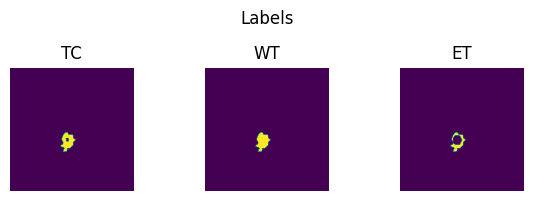

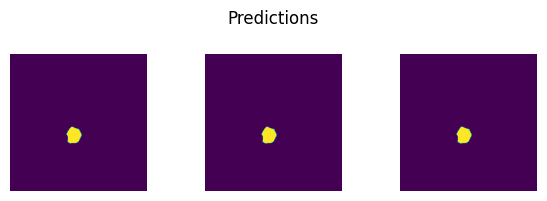

epoch 97
   average train loss: 0.4322
   average validation loss: 0.4724
   saved as best model: True
   current mean dice: 0.4290
   current TC dice: 0.4539
   current WT dice: 0.4621
   current ET dice: 0.4103
Best Mean Metric: 0.4290
time consuming of epoch 97 is: 1396.0484
----------
epoch 98/100
TRAIN
   Batch 1/248, train_loss: 0.1252, step time: 0.3420
   Batch 2/248, train_loss: 0.9686, step time: 0.3653
   Batch 3/248, train_loss: 0.5505, step time: 0.3707
   Batch 4/248, train_loss: 1.0000, step time: 0.3651
   Batch 5/248, train_loss: 0.3272, step time: 0.3452
   Batch 6/248, train_loss: 0.3822, step time: 0.3799
   Batch 7/248, train_loss: 0.1055, step time: 0.3397
   Batch 8/248, train_loss: 0.7024, step time: 0.3708
   Batch 9/248, train_loss: 0.0667, step time: 0.3694
   Batch 10/248, train_loss: 0.4127, step time: 0.3635
   Batch 11/248, train_loss: 0.3264, step time: 0.3460
   Batch 12/248, train_loss: 0.8022, step time: 0.3411
   Batch 13/248, train_loss: 0.6392, ste

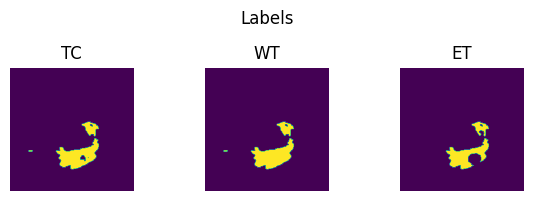

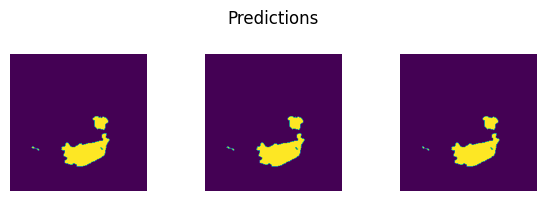

VAL
   Batch 1/31, val_loss: 0.4448
   Batch 2/31, val_loss: 0.5665
   Batch 3/31, val_loss: 0.5705
   Batch 4/31, val_loss: 0.5574
   Batch 5/31, val_loss: 0.6054
   Batch 6/31, val_loss: 0.0979
   Batch 7/31, val_loss: 0.2665
   Batch 8/31, val_loss: 0.4086
   Batch 9/31, val_loss: 0.1501
   Batch 10/31, val_loss: 0.5077
   Batch 11/31, val_loss: 0.3596
   Batch 12/31, val_loss: 0.5348
   Batch 13/31, val_loss: 0.4284
   Batch 14/31, val_loss: 0.5260
   Batch 15/31, val_loss: 0.5419
   Batch 16/31, val_loss: 0.5009
   Batch 17/31, val_loss: 0.4653
   Batch 18/31, val_loss: 0.4127
   Batch 19/31, val_loss: 0.1667
   Batch 20/31, val_loss: 0.4824
   Batch 21/31, val_loss: 0.5179
   Batch 22/31, val_loss: 0.5210
   Batch 23/31, val_loss: 0.4305
   Batch 24/31, val_loss: 0.0532
   Batch 25/31, val_loss: 0.2272
   Batch 26/31, val_loss: 0.5631
   Batch 27/31, val_loss: 0.5206
   Batch 28/31, val_loss: 0.3374
   Batch 29/31, val_loss: 0.5749
   Batch 30/31, val_loss: 0.5110
   Batch 31/31,

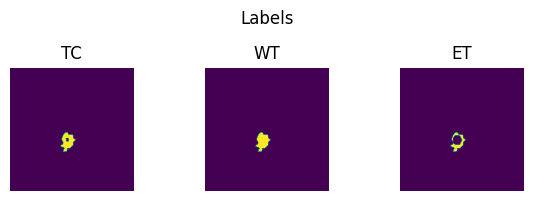

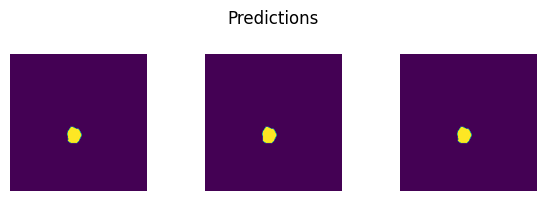

epoch 98
   average train loss: 0.4339
   average validation loss: 0.4304
   saved as best model: False
   current mean dice: 0.4200
   current TC dice: 0.4432
   current WT dice: 0.4509
   current ET dice: 0.4048
Best Mean Metric: 0.4290
time consuming of epoch 98 is: 1418.4400
----------
epoch 99/100
TRAIN
   Batch 1/248, train_loss: 0.1369, step time: 0.3463
   Batch 2/248, train_loss: 0.9587, step time: 0.3420
   Batch 3/248, train_loss: 0.6203, step time: 0.3669
   Batch 4/248, train_loss: 0.9999, step time: 0.3456
   Batch 5/248, train_loss: 0.3541, step time: 0.3523
   Batch 6/248, train_loss: 0.5627, step time: 0.3690
   Batch 7/248, train_loss: 0.1041, step time: 0.3447
   Batch 8/248, train_loss: 0.7466, step time: 0.3697
   Batch 9/248, train_loss: 0.0689, step time: 0.3600
   Batch 10/248, train_loss: 0.4293, step time: 0.3677
   Batch 11/248, train_loss: 0.3383, step time: 0.3537
   Batch 12/248, train_loss: 0.8732, step time: 0.3728
   Batch 13/248, train_loss: 0.7076, st

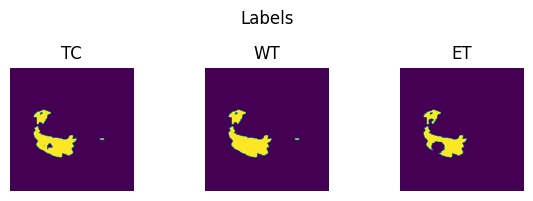

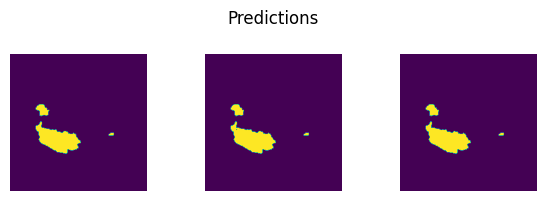

VAL
   Batch 1/31, val_loss: 0.4546
   Batch 2/31, val_loss: 0.5714
   Batch 3/31, val_loss: 0.5173
   Batch 4/31, val_loss: 0.5497
   Batch 5/31, val_loss: 0.5998
   Batch 6/31, val_loss: 0.1257
   Batch 7/31, val_loss: 0.3050
   Batch 8/31, val_loss: 0.4004
   Batch 9/31, val_loss: 0.1814
   Batch 10/31, val_loss: 0.5031
   Batch 11/31, val_loss: 0.3562
   Batch 12/31, val_loss: 0.5330
   Batch 13/31, val_loss: 0.4731
   Batch 14/31, val_loss: 0.5462
   Batch 15/31, val_loss: 0.5149
   Batch 16/31, val_loss: 0.4859
   Batch 17/31, val_loss: 0.4641
   Batch 18/31, val_loss: 0.4036
   Batch 19/31, val_loss: 0.1672
   Batch 20/31, val_loss: 0.5378
   Batch 21/31, val_loss: 0.5187
   Batch 22/31, val_loss: 0.5009
   Batch 23/31, val_loss: 0.4245
   Batch 24/31, val_loss: 0.0913
   Batch 25/31, val_loss: 0.2281
   Batch 26/31, val_loss: 0.5743
   Batch 27/31, val_loss: 0.5288
   Batch 28/31, val_loss: 0.3433
   Batch 29/31, val_loss: 0.5608
   Batch 30/31, val_loss: 0.4987
   Batch 31/31,

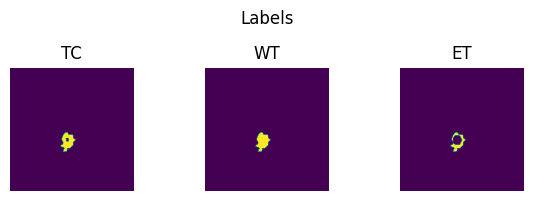

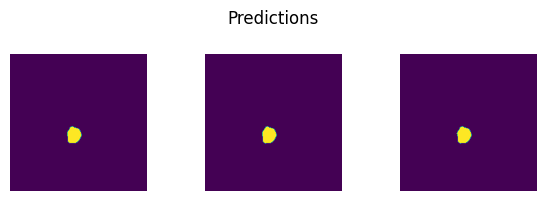

epoch 99
   average train loss: 0.4297
   average validation loss: 0.4343
   saved as best model: False
   current mean dice: 0.4239
   current TC dice: 0.4491
   current WT dice: 0.4567
   current ET dice: 0.4041
Best Mean Metric: 0.4290
time consuming of epoch 99 is: 1413.0590
----------
epoch 100/100
TRAIN
   Batch 1/248, train_loss: 0.1188, step time: 0.3666
   Batch 2/248, train_loss: 0.9742, step time: 0.3622
   Batch 3/248, train_loss: 0.6360, step time: 0.3671
   Batch 4/248, train_loss: 1.0000, step time: 0.3453
   Batch 5/248, train_loss: 0.4113, step time: 0.3658
   Batch 6/248, train_loss: 0.3786, step time: 0.3857
   Batch 7/248, train_loss: 0.1030, step time: 0.3850
   Batch 8/248, train_loss: 0.7082, step time: 0.3837
   Batch 9/248, train_loss: 0.0664, step time: 0.3686
   Batch 10/248, train_loss: 0.4135, step time: 0.3718
   Batch 11/248, train_loss: 0.3219, step time: 0.3791
   Batch 12/248, train_loss: 0.8163, step time: 0.3533
   Batch 13/248, train_loss: 0.7697, s

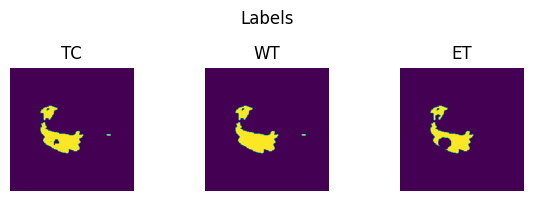

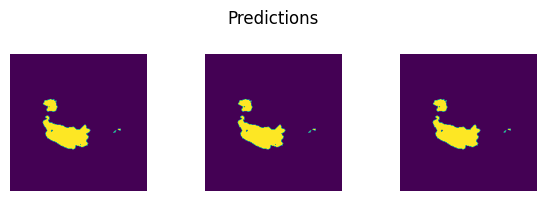

VAL
   Batch 1/31, val_loss: 0.4535
   Batch 2/31, val_loss: 0.5648
   Batch 3/31, val_loss: 0.5546
   Batch 4/31, val_loss: 0.5500
   Batch 5/31, val_loss: 0.5860
   Batch 6/31, val_loss: 0.0983
   Batch 7/31, val_loss: 0.2294
   Batch 8/31, val_loss: 0.3986
   Batch 9/31, val_loss: 0.1174
   Batch 10/31, val_loss: 0.4952
   Batch 11/31, val_loss: 0.3343
   Batch 12/31, val_loss: 0.5407
   Batch 13/31, val_loss: 0.4337
   Batch 14/31, val_loss: 0.5281
   Batch 15/31, val_loss: 0.5357
   Batch 16/31, val_loss: 0.5086
   Batch 17/31, val_loss: 0.4668
   Batch 18/31, val_loss: 0.3960
   Batch 19/31, val_loss: 0.1684
   Batch 20/31, val_loss: 0.4603
   Batch 21/31, val_loss: 0.5234
   Batch 22/31, val_loss: 0.5332
   Batch 23/31, val_loss: 0.3996
   Batch 24/31, val_loss: 0.0461
   Batch 25/31, val_loss: 0.2102
   Batch 26/31, val_loss: 0.5743
   Batch 27/31, val_loss: 0.5097
   Batch 28/31, val_loss: 0.3044
   Batch 29/31, val_loss: 0.5385
   Batch 30/31, val_loss: 0.4308
   Batch 31/31,

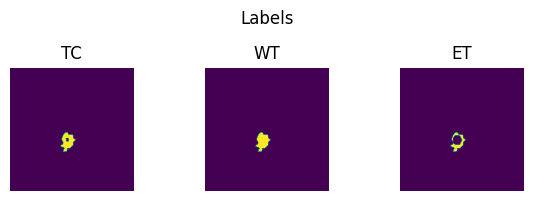

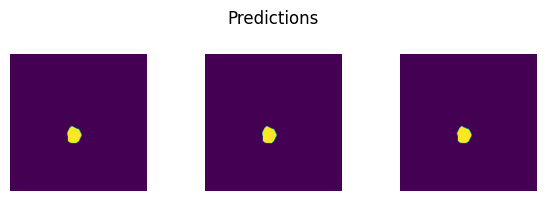

epoch 100
   average train loss: 0.4314
   average validation loss: 0.4187
   saved as best model: False
   current mean dice: 0.4204
   current TC dice: 0.4438
   current WT dice: 0.4515
   current ET dice: 0.4043
Best Mean Metric: 0.4290
time consuming of epoch 100 is: 1384.9170


In [ ]:
total_start = time.time()
for epoch in range(init_epoch, max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")

    # TRAINING
    model.train()
    epoch_loss = 0
    step = 0
    print('TRAIN')
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()

        # Batch Information
        print(f"   Batch {step}/{len(train_dataset) // train_loader.batch_size}"
              f", train_loss: {loss.item():.4f}"
              f", step time: {(time.time() - step_start):.4f}")

        # Store the image to plot
        if step == max_step:
          plt_imgs = [labels[0], transforms.post()(outputs[0])]

    # Epoch Training Loss
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)

    # Plot the Img
    if (epoch + 1) % plot_interval == 0:
      plot_gt_vs_pred(plt_imgs[0], plt_imgs[1], True)

    # VALIDATION
    print('VAL')
    val_loss = 0
    val_step = 0
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            best_val_dice = -1
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_step += 1
                val_outputs = inference(val_inputs)
                loss_value = loss_function(val_outputs[0], val_labels[0])
                val_loss += loss_value.item()

                val_outputs = [transforms.post()(x) for x in val_outputs]

                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

                # Batch Information
                print(f"   Batch {val_step}/{len(val_dataset) // val_loader.batch_size}"
                      f", val_loss: {loss_value.item():.4f}")

                # Store plot image
                if val_step == max_val_step:
                  plt_imgs = [val_labels[0], val_outputs[0]]

            # Epoch Validation Loss
            val_loss /= val_step
            val_loss_values.append(val_loss)

            # Plot the img
            if (epoch + 1) % plot_interval == 0:
              plot_gt_vs_pred(plt_imgs[0], plt_imgs[1], False)

            # Metric Calculation
            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_tc = metric_batch[0].item()
            metric_values_tc.append(metric_tc)
            metric_wt = metric_batch[1].item()
            metric_values_wt.append(metric_wt)
            metric_et = metric_batch[2].item()
            metric_values_et.append(metric_et)
            dice_metric.reset()
            dice_metric_batch.reset()

            # Save Last State
            torch.save(
                    model.state_dict(),
                    os.path.join(f"outputs/{model_name}/last_{model_name}_{epoch+1}.pth"),
            )

            # Remove previous state
            if epoch > 0:
                os.remove(
                      os.path.join(f"outputs/{model_name}/last_{model_name}_{epoch}.pth")
                )

            # Update Best Metric
            if metric > best_metric:
                # Save best state
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                # Save best model
                torch.save(
                    model.state_dict(),
                    os.path.join(f"outputs/{model_name}/best_{model_name}_{epoch+1}.pth"),
                )
                # Remove previous best model
                if best_metric_update_epoch != -1:
                    os.remove(
                        os.path.join(f"outputs/{model_name}/best_{model_name}_{best_metric_update_epoch}.pth")
                    )
                # Update best epoch
                best_metric_update_epoch = epoch + 1
                best_metric_update = True

            # Save all metrics in csv
            with open(f"outputs/{model_name}/{model_name}_metrics.csv", "a") as f:
                f.write(f"{epoch + 1},{metric},{metric_tc},{metric_wt},{metric_et},{epoch_loss},{val_loss}\n")

    # REPORT
    print(f"epoch {epoch + 1}\n"
          f"   average train loss: {epoch_loss:.4f}\n"
          f"   average validation loss: {val_loss:.4f}\n"
          f"   saved as best model: {best_metric_update}\n"
          f"   current mean dice: {metric_values[-1]:.4f}\n"
          f"   current TC dice: {metric_values_tc[-1]:.4f}\n"
          f"   current WT dice: {metric_values_wt[-1]:.4f}\n"
          f"   current ET dice: {metric_values_et[-1]:.4f}")
    print(f"Best Mean Metric: {best_metric:.4f}")
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
    best_metric_update = False

    # When epoch ends, clean GPU memory
    torch.cuda.empty_cache()

total_time = time.time() - total_start

In [ ]:
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: {total_time}.")

train completed, best_metric: 0.4290 at epoch: 97, total time: 64391.0146882534.
